In [2]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [8]:
from lib.parsers.logParser import LogParser

l_parser = LogParser(log_folder='Logs/')

main_data, values_data, order_data = l_parser.parse_train_sample(0, 10)

list_ua = pd.DataFrame(main_data).User_Agent.value_counts().index.tolist()

# For NaN Useragent
list_ua.append('0')

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


In [16]:
main = pd.DataFrame(main_data)

main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]

list_ua = main.User_Agent.value_counts()[:100].index.tolist()

values_data_top_100 = []

for row_index in tqdm(range(len(values_data))):
    if row_index in main_top_100.index:
        values_data_top_100.append(values_data[row_index])
        
order_data_top_100 = []

for row_index in tqdm(range(len(order_data))):
    if row_index in main_top_100.index:
        order_data_top_100.append(values_data[row_index])

100%|██████████| 289269/289269 [00:00<00:00, 695577.62it/s]


In [22]:
orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
values_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)

important_keys_set = {'Accept', 'Accept-Charset', 'Accept-Encoding'}

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(list_ua)
y = lb.transform(pd.DataFrame(main_top_100).User_Agent.fillna('0'))

 30%|███       | 54961/181851 [00:00<00:00, 549607.90it/s]

Sparse dummy orders shape: 
(181851, 1216)


100%|██████████| 181851/181851 [00:00<00:00, 545594.89it/s]


Sparse dummy values shape: 
(181851, 93)


### Sample

In [23]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

In [24]:
%%time
clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)

CPU times: user 6min 57s, sys: 332 ms, total: 6min 57s
Wall time: 6min 59s


In [25]:
%%time

from lib.thresholdPredictions import ThresholdPredictions

pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

60011it [00:01, 35976.14it/s]

CPU times: user 6.64 s, sys: 24 ms, total: 6.66 s
Wall time: 6.68 s


In [26]:
compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

sparse_dummy_values.shape: (181851, 1309)
Answers Count (Average) = 5.135991734848611
True Positive = 0.9551415573811468


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,6
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,12
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,13
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


## Dimensionality reduction

### Full headers key list

In [140]:
order_keys = {'Accept'}

for header in tqdm(order_data):
    for key in header.keys():
        order_keys.add(key)

print("keys count: {}".format(len(order_keys)))
order_keys

100%|██████████| 289269/289269 [00:00<00:00, 626278.66it/s]

keys count: 174


{'Accept',
 'Accept-Charset',
 'Accept-Encoding',
 'Accept-Language',
 'Authorization',
 'Cache-Control',
 'Cdn-Src-Ip',
 'Charset',
 'Chrome-Proxy',
 'Chrome-Proxy-Accept-Transform',
 'Client-Ip',
 'Clientip',
 'Cmd',
 'Connection',
 'Content-Length',
 'Content-Range',
 'Content-Type',
 'Cookie',
 'Cookie2',
 'Date',
 'Device-Stock-Ua',
 'Dnt',
 'Drm-Version',
 'F5-User-Ip',
 'Forwarded',
 'Forwarded-For',
 'From',
 'Giga-Transport',
 'Host',
 'Http2-Settings',
 'Https',
 'If-Modified-Since',
 'If-None-Match',
 'Inter-Pro-Client',
 'Keep-Alive',
 'O2gw-Id',
 'Origin',
 'Oxpry-Connection',
 'Ping-From',
 'Ping-To',
 'Pragma',
 'Prefer',
 'Proxy-Authorization',
 'Proxy-Connection',
 'Purpose',
 'Q-Refer',
 'Q-Ua',
 'Range',
 'Referer',
 'Refresh-Cache',
 'Rmch-Securitycookie',
 'Rvbd-Csh',
 'Rvbd-Ssh',
 'Save-Data',
 'Scheme',
 'Surrogate-Capability',
 'Te',
 'Ua-Cpu',
 'Upgrade',
 'Upgrade-Insecure-Requests',
 'User-Agent',
 'Useragent',
 'Version',
 'Via',
 'Wap-Connection',
 'Wapconn

### Greedy selection

In [29]:
%%time

real_keys = []
o_shapes = []
o_averages = []
o_tp = []

for key in tqdm(order_keys):
    real_keys.append(key)
    if len(real_keys) < 2:
        continue

    order_data_top_100 = []

    for row_index in range(len(order_data)):
        tmp_row = {}
        for key in order_data[row_index].keys():
            if key in real_keys:
                tmp_row[key] = order_data[row_index][key]
        if row_index in main_top_100.index:
            order_data_top_100.append(tmp_row)

    l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

    full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

    X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

    clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
    clf.fit(X_train, y_train)
    
    pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
    y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)
    
    o_shapes.append(full_sparce_dummy.shape[1])
    o_averages.append(np.average(answers_count))
    o_tp.append(np.sum(compare_answers) / y_test.shape[0])

 26%|██▌       | 47450/181851 [00:00<00:00, 474443.89it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 483507.18it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3513it [00:00, 35129.28it/s]
6955it [00:00, 34912.21it/s]
10301it [00:00, 34460.42it/s]
13810it [00:00, 34646.48it/s]
17302it [00:00, 34727.80it/s]
20850it [00:00, 34949.75it/s]
24195it [00:00, 34485.55it/s]
27817it [00:00, 34985.51it/s]
31343it [00:00, 35067.00it/s]
34938it [00:01, 35324.81it/s]
38425it [00:01, 35186.22it/s]
41876it [00:01, 33963.44it/s]
45354it [00:01, 34203.26it/s]
48748it [00:01, 33077.08it/s]
52090it [00:01, 33178.16it/s]
55412it [00:01, 33188.06it/s]
58726it [00:01, 33136.95it/s]
 29%|██▊       | 52205/181851 [00:00<00:00, 522041.79it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 521602.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3572it [00:00, 35718.16it/s]
7221it [00:00, 35945.94it/s]
10843it [00:00, 36026.99it/s]
14486it [00:00, 36144.71it/s]
18112it [00:00, 36178.17it/s]
21651it [00:00, 35936.24it/s]
25264it [00:00, 35993.06it/s]
28612it [00:00, 35197.84it/s]
32192it [00:00, 35375.31it/s]
35615it [00:01, 35022.74it/s]
39205it [00:01, 35279.38it/s]
42801it [00:01, 35479.53it/s]
46388it [00:01, 35593.33it/s]
49915it [00:01, 35020.73it/s]
53396it [00:01, 34539.50it/s]
56972it [00:01, 34895.14it/s]
 30%|██▉       | 54118/181851 [00:00<00:00, 541172.77it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 538696.61it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3476it [00:00, 34758.71it/s]
7112it [00:00, 35223.93it/s]
10655it [00:00, 35284.02it/s]
14182it [00:00, 35278.56it/s]
17828it [00:00, 35624.49it/s]
21409it [00:00, 35679.44it/s]
24805it [00:00, 35144.73it/s]
28433it [00:00, 35475.01it/s]
31783it [00:00, 33915.43it/s]
35136it [00:01, 33798.37it/s]
38506it [00:01, 33767.55it/s]
42108it [00:01, 34411.69it/s]
45633it [00:01, 34657.20it/s]
49205it [00:01, 34968.17it/s]
52856it [00:01, 35414.87it/s]
56439it [00:01, 35534.12it/s]
 29%|██▉       | 52913/181851 [00:00<00:00, 529125.46it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 523637.24it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3524it [00:00, 35235.41it/s]
6984it [00:00, 35040.05it/s]
10494it [00:00, 35057.25it/s]
14091it [00:00, 35324.22it/s]
17706it [00:00, 35567.80it/s]
21321it [00:00, 35739.99it/s]
24988it [00:00, 36013.02it/s]
28612it [00:00, 36079.29it/s]
32238it [00:00, 36132.60it/s]
35878it [00:01, 36210.48it/s]
39519it [00:01, 36267.43it/s]
43151it [00:01, 36282.86it/s]
46757it [00:01, 36213.77it/s]
50368it [00:01, 36181.42it/s]
53989it [00:01, 36187.03it/s]
57592it [00:01, 36123.35it/s]
 29%|██▉       | 52900/181851 [00:00<00:00, 528981.59it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 529757.05it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3599it [00:00, 35983.00it/s]
7222it [00:00, 36056.04it/s]
10836it [00:00, 36079.01it/s]
14449it [00:00, 36092.75it/s]
18077it [00:00, 36147.03it/s]
21653it [00:00, 36027.43it/s]
25227it [00:00, 35940.68it/s]
28798it [00:00, 35868.75it/s]
32347it [00:00, 35751.58it/s]
35917it [00:01, 35733.65it/s]
39510it [00:01, 35788.74it/s]
43130it [00:01, 35909.49it/s]
46706it [00:01, 35862.93it/s]
50375it [00:01, 36106.89it/s]
53962it [00:01, 35774.95it/s]
57592it [00:01, 35929.39it/s]
 29%|██▉       | 53515/181851 [00:00<00:00, 535146.68it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 529395.61it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3385it [00:00, 33844.95it/s]
6550it [00:00, 33155.11it/s]
10117it [00:00, 33871.43it/s]
13727it [00:00, 34510.50it/s]
16759it [00:00, 33134.22it/s]
20157it [00:00, 33381.14it/s]
23293it [00:00, 32746.11it/s]
26742it [00:00, 33250.14it/s]
30294it [00:00, 33899.85it/s]
33828it [00:01, 34318.47it/s]
37327it [00:01, 34515.29it/s]
40777it [00:01, 34507.87it/s]
44242it [00:01, 34549.81it/s]
47748it [00:01, 34700.20it/s]
51264it [00:01, 34814.38it/s]
54732it [00:01, 34054.43it/s]
58243it [00:01, 34362.34it/s]
 29%|██▉       | 52528/181851 [00:00<00:00, 525272.99it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 506347.36it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3603it [00:00, 36021.53it/s]
7286it [00:00, 36259.36it/s]
10900it [00:00, 36223.17it/s]
14467it [00:00, 36054.58it/s]
17969it [00:00, 35735.53it/s]
21308it [00:00, 34996.11it/s]
24887it [00:00, 35229.40it/s]
28268it [00:00, 34789.46it/s]
31543it [00:00, 33160.97it/s]
34963it [00:01, 33464.34it/s]
38513it [00:01, 34043.49it/s]
41907it [00:01, 34009.54it/s]
45512it [00:01, 34595.61it/s]
49054it [00:01, 34838.73it/s]
52641it [00:01, 35140.49it/s]
56171it [00:01, 35186.24it/s]
59682it [00:01, 35035.92it/s]
 28%|██▊       | 50063/181851 [00:00<00:00, 500620.93it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 463772.80it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3622it [00:00, 36218.39it/s]
7225it [00:00, 36160.20it/s]
10909it [00:00, 36360.35it/s]
14522it [00:00, 36289.09it/s]
18133it [00:00, 36234.15it/s]
21783it [00:00, 36311.70it/s]
25423it [00:00, 36337.45it/s]
29061it [00:00, 36350.19it/s]
32707it [00:00, 36380.79it/s]
36436it [00:01, 36646.94it/s]
40092it [00:01, 36619.12it/s]
43718it [00:01, 36509.86it/s]
47320it [00:01, 36134.43it/s]
50900it [00:01, 34267.98it/s]
54324it [00:01, 33961.06it/s]
57727it [00:01, 33981.38it/s]
 30%|███       | 55076/181851 [00:00<00:00, 550747.39it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 561644.41it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3543it [00:00, 35424.63it/s]
7166it [00:00, 35662.21it/s]
10729it [00:00, 35651.28it/s]
14391it [00:00, 35934.79it/s]
18095it [00:00, 36258.33it/s]
21763it [00:00, 36383.49it/s]
25479it [00:00, 36611.73it/s]
29216it [00:00, 36835.30it/s]
32921it [00:00, 36897.49it/s]
36541it [00:01, 36684.09it/s]
40111it [00:01, 36360.96it/s]
43679it [00:01, 35938.04it/s]
47226it [00:01, 34425.11it/s]
50650it [00:01, 34121.90it/s]
54161it [00:01, 34410.95it/s]
57742it [00:01, 34816.88it/s]
 31%|███       | 55734/181851 [00:00<00:00, 557339.20it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 557450.12it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3703it [00:00, 37024.21it/s]
7417it [00:00, 37057.00it/s]
11202it [00:00, 37289.33it/s]
14955it [00:00, 37358.93it/s]
18657it [00:00, 37255.38it/s]
22392it [00:00, 37281.33it/s]
26153it [00:00, 37378.35it/s]
29896it [00:00, 37392.91it/s]
33640it [00:00, 37405.56it/s]
37396it [00:01, 37449.66it/s]
41168it [00:01, 37529.80it/s]
44901it [00:01, 37468.49it/s]
48662it [00:01, 37509.83it/s]
52381it [00:01, 37412.37it/s]
56115it [00:01, 37388.53it/s]
59933it [00:01, 37621.50it/s]
 33%|███▎      | 59680/181851 [00:00<00:00, 596796.30it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 592558.99it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3662it [00:00, 36615.50it/s]
7367it [00:00, 36743.17it/s]
11063it [00:00, 36806.23it/s]
14733it [00:00, 36771.38it/s]
18423it [00:00, 36809.86it/s]
22156it [00:00, 36964.12it/s]
25862it [00:00, 36990.91it/s]
29602it [00:00, 37112.47it/s]
33358it [00:00, 37245.38it/s]
37108it [00:01, 37317.61it/s]
40884it [00:01, 37447.04it/s]
44683it [00:01, 37605.80it/s]
48424it [00:01, 37544.16it/s]
52157it [00:01, 37477.16it/s]
55892it [00:01, 37437.51it/s]
59635it [00:01, 37434.97it/s]
 32%|███▏      | 58837/181851 [00:00<00:00, 588360.74it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 585456.79it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3744it [00:00, 37433.43it/s]
7503it [00:00, 37478.35it/s]
11196it [00:00, 37311.51it/s]
14933it [00:00, 37328.03it/s]
18657it [00:00, 37298.76it/s]
22385it [00:00, 37292.74it/s]
26146it [00:00, 37386.86it/s]
29864it [00:00, 37324.22it/s]
33656it [00:00, 37499.77it/s]
37385it [00:01, 37436.09it/s]
41183it [00:01, 37597.29it/s]
44947it [00:01, 37607.47it/s]
48725it [00:01, 37657.73it/s]
52485it [00:01, 37640.16it/s]
56260it [00:01, 37672.36it/s]
 33%|███▎      | 60082/181851 [00:00<00:00, 600817.71it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 589040.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3745it [00:00, 37449.14it/s]
7522it [00:00, 37544.81it/s]
11296it [00:00, 37602.28it/s]
15054it [00:00, 37593.48it/s]
18801it [00:00, 37554.29it/s]
22519it [00:00, 37441.03it/s]
26242it [00:00, 37375.15it/s]
29754it [00:00, 36664.70it/s]
33358it [00:00, 36472.58it/s]
36994it [00:01, 36437.13it/s]
40638it [00:01, 36437.53it/s]
44312it [00:01, 36526.09it/s]
47990it [00:01, 36599.82it/s]
51693it [00:01, 36725.12it/s]
55477it [00:01, 37050.38it/s]
59269it [00:01, 37305.48it/s]
 32%|███▏      | 59047/181851 [00:00<00:00, 590463.52it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 587993.70it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3760it [00:00, 37598.24it/s]
7472it [00:00, 37450.03it/s]
10894it [00:00, 36417.03it/s]
14559it [00:00, 36484.62it/s]
18247it [00:00, 36602.06it/s]
21960it [00:00, 36757.80it/s]
25701it [00:00, 36950.94it/s]
29408it [00:00, 36986.09it/s]
33137it [00:00, 37075.67it/s]
36826it [00:01, 37019.31it/s]
40499it [00:01, 36931.62it/s]
44182it [00:01, 36899.69it/s]
47875it [00:01, 36908.07it/s]
51580it [00:01, 36948.94it/s]
55275it [00:01, 36948.08it/s]
58975it [00:01, 36961.59it/s]
 32%|███▏      | 58240/181851 [00:00<00:00, 582390.84it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 580491.37it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3688it [00:00, 36875.82it/s]
7385it [00:00, 36903.11it/s]
11097it [00:00, 36966.37it/s]
14788it [00:00, 36946.75it/s]
18479it [00:00, 36935.09it/s]
22065it [00:00, 36603.09it/s]
25842it [00:00, 36943.85it/s]
29625it [00:00, 37203.27it/s]
33407it [00:00, 37384.54it/s]
37141it [00:01, 37370.03it/s]
40910it [00:01, 37464.87it/s]
44707it [00:01, 37614.15it/s]
48498it [00:01, 37701.20it/s]
52285it [00:01, 37749.46it/s]
56098it [00:01, 37861.89it/s]
59906it [00:01, 37925.88it/s]
 33%|███▎      | 60184/181851 [00:00<00:00, 601839.14it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 589334.85it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3743it [00:00, 37423.70it/s]
7509it [00:00, 37490.31it/s]
11253it [00:00, 37472.00it/s]
15004it [00:00, 37482.35it/s]
18791it [00:00, 37594.33it/s]
22491it [00:00, 37411.36it/s]
26215it [00:00, 37357.66it/s]
29903it [00:00, 37210.85it/s]
33651it [00:00, 37290.69it/s]
37406it [00:01, 37366.95it/s]
41195it [00:01, 37519.53it/s]
44948it [00:01, 37520.56it/s]
48704it [00:01, 37528.70it/s]
52421it [00:01, 37377.36it/s]
56198it [00:01, 37491.83it/s]
59974it [00:01, 37568.84it/s]
 33%|███▎      | 59563/181851 [00:00<00:00, 595622.05it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 596538.09it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3685it [00:00, 36845.91it/s]
7404it [00:00, 36946.66it/s]
11106it [00:00, 36967.75it/s]
14798it [00:00, 36950.64it/s]
18454it [00:00, 36830.36it/s]
22162it [00:00, 36902.17it/s]
25834it [00:00, 36846.95it/s]
29547it [00:00, 36930.76it/s]
33341it [00:00, 37226.84it/s]
37091it [00:01, 37307.21it/s]
40861it [00:01, 37421.46it/s]
44653it [00:01, 37568.77it/s]
48445it [00:01, 37672.29it/s]
52214it [00:01, 37676.02it/s]
55961it [00:01, 37611.45it/s]
59705it [00:01, 37503.94it/s]
 33%|███▎      | 59256/181851 [00:00<00:00, 592492.76it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 588300.28it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37395.58it/s]
7514it [00:00, 37496.41it/s]
11297it [00:00, 37595.13it/s]
15046it [00:00, 37563.52it/s]
18691it [00:00, 37221.77it/s]
22376it [00:00, 37107.24it/s]
25998it [00:00, 36835.64it/s]
29548it [00:00, 36423.48it/s]
33190it [00:00, 36421.12it/s]
36941it [00:01, 36738.50it/s]
40592it [00:01, 36669.50it/s]
44300it [00:01, 36791.63it/s]
47948it [00:01, 36694.21it/s]
51582it [00:01, 36530.94it/s]
55216it [00:01, 36473.33it/s]
58866it [00:01, 36480.66it/s]
 33%|███▎      | 59731/181851 [00:00<00:00, 597306.30it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 595426.04it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3742it [00:00, 37413.52it/s]
7528it [00:00, 37543.65it/s]
11360it [00:00, 37770.77it/s]
15175it [00:00, 37881.57it/s]
18977it [00:00, 37922.93it/s]
22758it [00:00, 37888.28it/s]
26559it [00:00, 37923.64it/s]
30362it [00:00, 37954.33it/s]
34223it [00:00, 38146.40it/s]
37986it [00:01, 37989.60it/s]
41766it [00:01, 37930.30it/s]
45486it [00:01, 37459.85it/s]
49261it [00:01, 37544.94it/s]
52981it [00:01, 37290.31it/s]
56758it [00:01, 37430.93it/s]
 32%|███▏      | 58688/181851 [00:00<00:00, 586873.56it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 586316.37it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3617it [00:00, 36169.86it/s]
7312it [00:00, 36398.95it/s]
10949it [00:00, 36388.89it/s]
14622it [00:00, 36487.92it/s]
18293it [00:00, 36552.32it/s]
21938it [00:00, 36521.21it/s]
25584it [00:00, 36500.40it/s]
29196it [00:00, 36382.68it/s]
32845it [00:00, 36410.92it/s]
36479it [00:01, 36387.96it/s]
40131it [00:01, 36416.10it/s]
43792it [00:01, 36473.31it/s]
47446it [00:01, 36492.68it/s]
51126it [00:01, 36584.11it/s]
54831it [00:01, 36722.03it/s]
58526it [00:01, 36788.17it/s]
 33%|███▎      | 59643/181851 [00:00<00:00, 596423.46it/s]

Sparse dummy orders shape: 
(181851, 5)



100%|██████████| 181851/181851 [00:00<00:00, 583791.64it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3743it [00:00, 37423.17it/s]
7473it [00:00, 37384.88it/s]
11178it [00:00, 37283.47it/s]
14903it [00:00, 37272.93it/s]
18595it [00:00, 37164.99it/s]
22290it [00:00, 37098.51it/s]
25954it [00:00, 36959.05it/s]
29627it [00:00, 36888.93it/s]
33317it [00:00, 36889.89it/s]
37082it [00:01, 37111.86it/s]
40775it [00:01, 37057.10it/s]
44510it [00:01, 37143.60it/s]
48203it [00:01, 37078.87it/s]
51937it [00:01, 37156.76it/s]
55644it [00:01, 37130.14it/s]
59340it [00:01, 37051.03it/s]
 33%|███▎      | 59931/181851 [00:00<00:00, 599304.86it/s]

Sparse dummy orders shape: 
(181851, 8)



100%|██████████| 181851/181851 [00:00<00:00, 600539.31it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37396.29it/s]
7542it [00:00, 37580.54it/s]
11352it [00:00, 37734.63it/s]
15104it [00:00, 37667.58it/s]
18616it [00:00, 36863.46it/s]
22152it [00:00, 36398.69it/s]
25854it [00:00, 36582.17it/s]
29649it [00:00, 36981.88it/s]
33339it [00:00, 36956.31it/s]
36952it [00:01, 36703.10it/s]
40710it [00:01, 36961.13it/s]
44493it [00:01, 37217.03it/s]
48286it [00:01, 37426.17it/s]
52161it [00:01, 37812.68it/s]
55919it [00:01, 37684.44it/s]
59672it [00:01, 37529.06it/s]
 33%|███▎      | 60538/181851 [00:00<00:00, 605376.25it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 598391.38it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3656it [00:00, 36552.54it/s]
7367it [00:00, 36716.26it/s]
11103it [00:00, 36904.54it/s]
14806it [00:00, 36940.13it/s]
18529it [00:00, 37024.99it/s]
22240it [00:00, 37049.77it/s]
25961it [00:00, 37095.33it/s]
29668it [00:00, 37085.00it/s]
33374it [00:00, 37076.47it/s]
37144it [00:01, 37261.05it/s]
40869it [00:01, 37257.08it/s]
44641it [00:01, 37394.34it/s]
48331it [00:01, 37233.24it/s]
52061it [00:01, 37250.43it/s]
55781it [00:01, 37233.11it/s]
59532it [00:01, 37313.72it/s]
 33%|███▎      | 59327/181851 [00:00<00:00, 593262.08it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 594706.45it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3710it [00:00, 37099.86it/s]
7504it [00:00, 37346.69it/s]
11297it [00:00, 37518.00it/s]
15045it [00:00, 37503.94it/s]
18780it [00:00, 37457.37it/s]
22549it [00:00, 37526.09it/s]
26310it [00:00, 37549.33it/s]
30061it [00:00, 37535.17it/s]
33904it [00:00, 37795.61it/s]
37714it [00:01, 37885.05it/s]
41502it [00:01, 37882.73it/s]
45324it [00:01, 37980.54it/s]
49148it [00:01, 38055.53it/s]
52918it [00:01, 37879.75it/s]
56682it [00:01, 37683.90it/s]
 32%|███▏      | 57934/181851 [00:00<00:00, 579339.17it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 580892.35it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3766it [00:00, 37652.41it/s]
7592it [00:00, 37832.07it/s]
11370it [00:00, 37813.74it/s]
15173it [00:00, 37875.75it/s]
18964it [00:00, 37881.21it/s]
22690it [00:00, 37691.93it/s]
26411it [00:00, 37545.65it/s]
30109it [00:00, 37373.64it/s]
33853it [00:00, 37392.15it/s]
37627it [00:01, 37494.96it/s]
41422it [00:01, 37629.29it/s]
45219it [00:01, 37729.85it/s]
49003it [00:01, 37761.71it/s]
52792it [00:01, 37799.33it/s]
56621it [00:01, 37943.42it/s]
 33%|███▎      | 59310/181851 [00:00<00:00, 593096.32it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 587051.48it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3673it [00:00, 36723.99it/s]
7388it [00:00, 36849.42it/s]
11150it [00:00, 37075.59it/s]
14929it [00:00, 37284.84it/s]
18687it [00:00, 37370.41it/s]
22424it [00:00, 37368.27it/s]
26180it [00:00, 37423.16it/s]
29977it [00:00, 37583.60it/s]
33769it [00:00, 37682.35it/s]
37560it [00:01, 37748.24it/s]
41341it [00:01, 37764.49it/s]
45112it [00:01, 37747.68it/s]
48915it [00:01, 37830.73it/s]
52695it [00:01, 37821.00it/s]
56478it [00:01, 37822.50it/s]
 33%|███▎      | 59501/181851 [00:00<00:00, 595006.31it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 594081.12it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3721it [00:00, 37201.70it/s]
7458it [00:00, 37251.35it/s]
11219it [00:00, 37357.86it/s]
14996it [00:00, 37478.73it/s]
18752it [00:00, 37502.60it/s]
22501it [00:00, 37497.84it/s]
26268it [00:00, 37549.20it/s]
30055it [00:00, 37643.46it/s]
33841it [00:00, 37705.89it/s]
37597it [00:01, 37659.77it/s]
41409it [00:01, 37794.59it/s]
45240it [00:01, 37947.04it/s]
49058it [00:01, 38015.15it/s]
52849it [00:01, 37982.06it/s]
56664it [00:01, 38031.32it/s]
 33%|███▎      | 59179/181851 [00:00<00:00, 591783.51it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 587946.11it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37393.44it/s]
7493it [00:00, 37433.54it/s]
11244it [00:00, 37455.33it/s]
14981it [00:00, 37427.42it/s]
18708it [00:00, 37378.38it/s]
22433it [00:00, 37338.66it/s]
26173it [00:00, 37354.92it/s]
29898it [00:00, 37323.12it/s]
33642it [00:00, 37357.27it/s]
37452it [00:01, 37574.79it/s]
41219it [00:01, 37600.65it/s]
44956it [00:01, 37529.39it/s]
48674it [00:01, 37422.04it/s]
52413it [00:01, 37410.13it/s]
56149it [00:01, 37393.69it/s]
59951it [00:01, 37578.20it/s]
 32%|███▏      | 58234/181851 [00:00<00:00, 582335.00it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 587764.43it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3745it [00:00, 37445.13it/s]
7566it [00:00, 37669.58it/s]
11345it [00:00, 37704.02it/s]
15144it [00:00, 37787.63it/s]
18926it [00:00, 37796.48it/s]
22722it [00:00, 37845.02it/s]
26535it [00:00, 37928.78it/s]
30020it [00:00, 36855.41it/s]
33550it [00:00, 36373.01it/s]
37263it [00:01, 36594.92it/s]
40993it [00:01, 36803.23it/s]
44812it [00:01, 37206.89it/s]
48635it [00:01, 37506.09it/s]
52471it [00:01, 37757.51it/s]
56224it [00:01, 37384.82it/s]
 33%|███▎      | 60077/181851 [00:00<00:00, 600764.84it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 601819.16it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3641it [00:00, 36405.17it/s]
7382it [00:00, 36698.91it/s]
11093it [00:00, 36818.62it/s]
14817it [00:00, 36943.81it/s]
18541it [00:00, 37029.99it/s]
22239it [00:00, 37011.47it/s]
25940it [00:00, 37009.34it/s]
29675it [00:00, 37110.29it/s]
33372it [00:00, 37067.97it/s]
37148it [00:01, 37272.17it/s]
40993it [00:01, 37617.52it/s]
44827it [00:01, 37828.86it/s]
48602it [00:01, 37805.02it/s]
52358it [00:01, 37728.15it/s]
56138it [00:01, 37747.37it/s]
59903it [00:01, 37715.33it/s]
 33%|███▎      | 60139/181851 [00:00<00:00, 601389.14it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 600438.62it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3800it [00:00, 37992.07it/s]
7635it [00:00, 38096.21it/s]
11444it [00:00, 38092.23it/s]
15277it [00:00, 38160.41it/s]
19106it [00:00, 38196.59it/s]
22912it [00:00, 38153.30it/s]
26750it [00:00, 38219.08it/s]
30529it [00:00, 38088.50it/s]
34317it [00:00, 38023.12it/s]
38143it [00:01, 38093.24it/s]
42010it [00:01, 38263.60it/s]
45895it [00:01, 38436.06it/s]
49765it [00:01, 38514.30it/s]
53580it [00:01, 38361.37it/s]
57398it [00:01, 38305.11it/s]
 32%|███▏      | 58986/181851 [00:00<00:00, 589856.34it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 595895.87it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3687it [00:00, 36861.07it/s]
7452it [00:00, 37093.87it/s]
11201it [00:00, 37210.49it/s]
14947it [00:00, 37282.09it/s]
18672it [00:00, 37270.95it/s]
22462it [00:00, 37456.54it/s]
26214it [00:00, 37474.60it/s]
30038it [00:00, 37700.70it/s]
33817it [00:00, 37726.19it/s]
37616it [00:01, 37802.73it/s]
41377it [00:01, 37744.04it/s]
45156it [00:01, 37755.94it/s]
48966it [00:01, 37857.49it/s]
52724it [00:01, 37772.03it/s]
56501it [00:01, 37770.92it/s]
 33%|███▎      | 60380/181851 [00:00<00:00, 603793.38it/s]

Sparse dummy orders shape: 
(181851, 10)



100%|██████████| 181851/181851 [00:00<00:00, 608841.51it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3665it [00:00, 36642.17it/s]
7329it [00:00, 36641.27it/s]
11051it [00:00, 36810.84it/s]
14773it [00:00, 36931.44it/s]
18515it [00:00, 37074.29it/s]
22205it [00:00, 37017.93it/s]
25880it [00:00, 36936.25it/s]
29597it [00:00, 37005.68it/s]
33316it [00:00, 37059.95it/s]
37120it [00:01, 37348.50it/s]
40900it [00:01, 37480.19it/s]
44692it [00:01, 37609.50it/s]
48494it [00:01, 37729.64it/s]
52263it [00:01, 37717.15it/s]
56065it [00:01, 37806.30it/s]
59829it [00:01, 37730.14it/s]
 32%|███▏      | 57970/181851 [00:00<00:00, 579692.26it/s]

Sparse dummy orders shape: 
(181851, 11)



100%|██████████| 181851/181851 [00:00<00:00, 584994.74it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3755it [00:00, 37542.70it/s]
7482it [00:00, 37459.16it/s]
11213it [00:00, 37413.71it/s]
14957it [00:00, 37420.16it/s]
18714it [00:00, 37462.72it/s]
22454it [00:00, 37443.36it/s]
26181it [00:00, 37389.34it/s]
29916it [00:00, 37376.95it/s]
33710it [00:00, 37543.88it/s]
37454it [00:01, 37509.89it/s]
41242it [00:01, 37619.27it/s]
44965it [00:01, 37499.27it/s]
48686it [00:01, 37411.09it/s]
52394it [00:01, 37310.61it/s]
56112it [00:01, 37270.81it/s]
59915it [00:01, 37495.14it/s]
 32%|███▏      | 58950/181851 [00:00<00:00, 589499.16it/s]

Sparse dummy orders shape: 
(181851, 11)



100%|██████████| 181851/181851 [00:00<00:00, 588806.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3659it [00:00, 36585.94it/s]
7438it [00:00, 36936.24it/s]
11209it [00:00, 37163.82it/s]
14953it [00:00, 37244.82it/s]
18715it [00:00, 37355.91it/s]
22448it [00:00, 37346.81it/s]
26162it [00:00, 37282.93it/s]
29714it [00:00, 36734.05it/s]
33499it [00:00, 37059.72it/s]
37262it [00:01, 37227.54it/s]
41055it [00:01, 37435.04it/s]
44865it [00:01, 37631.19it/s]
48661it [00:01, 37727.58it/s]
52400it [00:01, 37548.76it/s]
56131it [00:01, 37442.39it/s]
59966it [00:01, 37709.35it/s]
 33%|███▎      | 59749/181851 [00:00<00:00, 597484.87it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 598294.22it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3761it [00:00, 37605.28it/s]
7545it [00:00, 37674.25it/s]
11234it [00:00, 37432.87it/s]
15010it [00:00, 37530.24it/s]
18767it [00:00, 37541.01it/s]
22555it [00:00, 37637.91it/s]
26331it [00:00, 37673.44it/s]
30100it [00:00, 37675.51it/s]
33833it [00:00, 37570.58it/s]
37567it [00:01, 37499.74it/s]
41309it [00:01, 37473.94it/s]
44983it [00:01, 36796.61it/s]
48854it [00:01, 37348.34it/s]
52711it [00:01, 37703.64it/s]
56505it [00:01, 37773.17it/s]
 32%|███▏      | 58163/181851 [00:00<00:00, 581629.17it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 584211.07it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3756it [00:00, 37554.66it/s]
7539it [00:00, 37635.06it/s]
11322it [00:00, 37693.05it/s]
15091it [00:00, 37691.60it/s]
18808it [00:00, 37531.79it/s]
22642it [00:00, 37769.62it/s]
26373it [00:00, 37628.61it/s]
30186it [00:00, 37776.68it/s]
33983it [00:00, 37832.94it/s]
37616it [00:01, 36783.92it/s]
41195it [00:01, 36233.21it/s]
44751it [00:01, 35875.52it/s]
48292it [00:01, 35314.18it/s]
52020it [00:01, 35879.82it/s]
55753it [00:01, 36300.99it/s]
59464it [00:01, 36538.61it/s]
 32%|███▏      | 58682/181851 [00:00<00:00, 586819.16it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 586223.99it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3634it [00:00, 36338.82it/s]
7316it [00:00, 36480.33it/s]
11003it [00:00, 36595.55it/s]
14671it [00:00, 36620.64it/s]
18405it [00:00, 36831.12it/s]
22096it [00:00, 36852.57it/s]
25779it [00:00, 36845.15it/s]
29504it [00:00, 36965.53it/s]
33196it [00:00, 36951.13it/s]
36890it [00:01, 36947.11it/s]
40552it [00:01, 36847.37it/s]
44246it [00:01, 36874.36it/s]
47937it [00:01, 36884.97it/s]
51723it [00:01, 37171.40it/s]
55510it [00:01, 37378.11it/s]
59327it [00:01, 37610.09it/s]
 33%|███▎      | 59241/181851 [00:00<00:00, 592406.33it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 591442.45it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3757it [00:00, 37568.96it/s]
7583it [00:00, 37773.51it/s]
11404it [00:00, 37901.46it/s]
15243it [00:00, 38042.86it/s]
19046it [00:00, 38037.06it/s]
22868it [00:00, 38089.16it/s]
26731it [00:00, 38248.01it/s]
30539it [00:00, 38196.42it/s]
34365it [00:00, 38215.27it/s]
38210it [00:01, 38283.68it/s]
42052it [00:01, 38322.62it/s]
45877it [00:01, 38298.68it/s]
49714it [00:01, 38318.80it/s]
53588it [00:01, 38441.37it/s]
57407it [00:01, 38284.80it/s]
 33%|███▎      | 59903/181851 [00:00<00:00, 599024.86it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 603427.49it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3709it [00:00, 37082.34it/s]
7538it [00:00, 37436.13it/s]
11354it [00:00, 37649.82it/s]
15155it [00:00, 37756.84it/s]
18961it [00:00, 37846.62it/s]
22757it [00:00, 37880.46it/s]
26566it [00:00, 37942.82it/s]
30446it [00:00, 38194.18it/s]
34223it [00:00, 38065.86it/s]
38050it [00:01, 38126.80it/s]
41848it [00:01, 38081.04it/s]
45654it [00:01, 38071.80it/s]
49428it [00:01, 37969.83it/s]
53275it [00:01, 38116.44it/s]
57103it [00:01, 38163.30it/s]
 33%|███▎      | 59774/181851 [00:00<00:00, 597732.02it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 594659.16it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3742it [00:00, 37416.11it/s]
7525it [00:00, 37538.27it/s]
11317it [00:00, 37650.89it/s]
14790it [00:00, 36723.01it/s]
18418it [00:00, 36586.24it/s]
22088it [00:00, 36619.78it/s]
25760it [00:00, 36649.23it/s]
29435it [00:00, 36678.39it/s]
33212it [00:00, 36998.73it/s]
36997it [00:01, 37247.98it/s]
40784it [00:01, 37431.46it/s]
44557it [00:01, 37517.39it/s]
48363it [00:01, 37675.91it/s]
52194it [00:01, 37861.12it/s]
55986it [00:01, 37874.61it/s]
59763it [00:01, 37841.20it/s]
 34%|███▍      | 62088/181851 [00:00<00:00, 620864.31it/s]

Sparse dummy orders shape: 
(181851, 23)



100%|██████████| 181851/181851 [00:00<00:00, 622110.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3647it [00:00, 36465.51it/s]
7393it [00:00, 36756.35it/s]
11139it [00:00, 36964.53it/s]
14826it [00:00, 36934.33it/s]
18531it [00:00, 36967.96it/s]
22196it [00:00, 36870.52it/s]
25862it [00:00, 36806.41it/s]
29553it [00:00, 36836.02it/s]
33179it [00:00, 36660.33it/s]
36944it [00:01, 36949.55it/s]
40640it [00:01, 36950.03it/s]
44358it [00:01, 37016.04it/s]
48042it [00:01, 36960.33it/s]
51801it [00:01, 37146.47it/s]
55492it [00:01, 37032.60it/s]
59206it [00:01, 37064.29it/s]
 33%|███▎      | 59385/181851 [00:00<00:00, 593842.07it/s]

Sparse dummy orders shape: 
(181851, 23)



100%|██████████| 181851/181851 [00:00<00:00, 592323.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3670it [00:00, 36692.77it/s]
7417it [00:00, 36922.18it/s]
11180it [00:00, 37130.65it/s]
14942it [00:00, 37274.86it/s]
18663it [00:00, 37253.39it/s]
22419it [00:00, 37344.67it/s]
26225it [00:00, 37556.25it/s]
29972it [00:00, 37528.44it/s]
33788it [00:00, 37713.39it/s]
37567it [00:01, 37736.16it/s]
41407it [00:01, 37932.71it/s]
45174it [00:01, 37852.36it/s]
48954it [00:01, 37834.78it/s]
52703it [00:01, 37715.51it/s]
56466it [00:01, 37687.86it/s]
 32%|███▏      | 58765/181851 [00:00<00:00, 587649.16it/s]

Sparse dummy orders shape: 
(181851, 23)



100%|██████████| 181851/181851 [00:00<00:00, 587854.13it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3758it [00:00, 37566.24it/s]
7611it [00:00, 37850.07it/s]
11433it [00:00, 37958.31it/s]
15242it [00:00, 37995.43it/s]
19049it [00:00, 38015.09it/s]
22829it [00:00, 37949.12it/s]
26638it [00:00, 37988.98it/s]
30463it [00:00, 38065.22it/s]
34278it [00:00, 38088.69it/s]
38175it [00:01, 38346.88it/s]
42006it [00:01, 38334.59it/s]
45844it [00:01, 38346.24it/s]
49643it [00:01, 38237.14it/s]
53455it [00:01, 38201.82it/s]
57252it [00:01, 38130.48it/s]
 33%|███▎      | 60059/181851 [00:00<00:00, 600584.85it/s]

Sparse dummy orders shape: 
(181851, 23)



100%|██████████| 181851/181851 [00:00<00:00, 597161.12it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3698it [00:00, 36972.81it/s]
7502it [00:00, 37285.46it/s]
11258it [00:00, 37365.15it/s]
15059it [00:00, 37555.30it/s]
18782it [00:00, 37454.54it/s]
22562it [00:00, 37556.53it/s]
26289it [00:00, 37467.86it/s]
30065it [00:00, 37553.62it/s]
33806it [00:00, 37509.41it/s]
37536it [00:01, 37444.71it/s]
41225it [00:01, 37275.22it/s]
44970it [00:01, 37327.01it/s]
48709it [00:01, 37344.14it/s]
52548it [00:01, 37651.05it/s]
56336it [00:01, 37716.99it/s]
 32%|███▏      | 58663/181851 [00:00<00:00, 586626.36it/s]

Sparse dummy orders shape: 
(181851, 44)



100%|██████████| 181851/181851 [00:00<00:00, 590042.41it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3699it [00:00, 36986.51it/s]
7420it [00:00, 37052.89it/s]
11156it [00:00, 37142.15it/s]
14834it [00:00, 37030.48it/s]
18537it [00:00, 37029.13it/s]
22262it [00:00, 37091.77it/s]
25677it [00:00, 36154.91it/s]
29153it [00:00, 35724.44it/s]
32614it [00:00, 35380.09it/s]
36364it [00:01, 35990.08it/s]
39885it [00:01, 35745.89it/s]
43391it [00:01, 35153.13it/s]
46861it [00:01, 34665.83it/s]
50297it [00:01, 34505.28it/s]
54089it [00:01, 35462.17it/s]
57936it [00:01, 36313.37it/s]
 32%|███▏      | 59091/181851 [00:00<00:00, 590909.15it/s]

Sparse dummy orders shape: 
(181851, 54)



100%|██████████| 181851/181851 [00:00<00:00, 590905.44it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3749it [00:00, 37486.19it/s]
7532it [00:00, 37586.04it/s]
11273it [00:00, 37530.70it/s]
15011it [00:00, 37483.06it/s]
18755it [00:00, 37468.45it/s]
22492it [00:00, 37438.74it/s]
26207it [00:00, 37350.34it/s]
29945it [00:00, 37358.07it/s]
33667it [00:00, 37314.87it/s]
37464it [00:01, 37508.55it/s]
41244it [00:01, 37594.54it/s]
45014it [00:01, 37625.43it/s]
48753it [00:01, 37553.58it/s]
52479it [00:01, 37463.20it/s]
56215it [00:01, 37431.52it/s]
59961it [00:01, 37439.21it/s]
 33%|███▎      | 59729/181851 [00:00<00:00, 597284.87it/s]

Sparse dummy orders shape: 
(181851, 67)



100%|██████████| 181851/181851 [00:00<00:00, 591431.90it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3798it [00:00, 37973.88it/s]
7608it [00:00, 38011.12it/s]
11428it [00:00, 38065.81it/s]
15255it [00:00, 38126.25it/s]
19066it [00:00, 38119.01it/s]
22871it [00:00, 38096.06it/s]
26671it [00:00, 38064.61it/s]
30474it [00:00, 38053.74it/s]
34061it [00:00, 36997.28it/s]
37615it [00:01, 36547.44it/s]
41169it [00:01, 36189.92it/s]
44960it [00:01, 36687.10it/s]
48794it [00:01, 37165.48it/s]
52538it [00:01, 37245.30it/s]
56324it [00:01, 37425.02it/s]
 32%|███▏      | 58570/181851 [00:00<00:00, 585690.78it/s]

Sparse dummy orders shape: 
(181851, 70)



100%|██████████| 181851/181851 [00:00<00:00, 588543.14it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3634it [00:00, 36335.36it/s]
7334it [00:00, 36530.28it/s]
11072it [00:00, 36779.70it/s]
14823it [00:00, 36991.99it/s]
18537it [00:00, 37033.37it/s]
22246it [00:00, 37042.33it/s]
25945it [00:00, 37025.94it/s]
29647it [00:00, 37021.76it/s]
33348it [00:00, 37016.52it/s]
37090it [00:01, 37135.29it/s]
40911it [00:01, 37449.50it/s]
44644it [00:01, 37410.76it/s]
48397it [00:01, 37445.58it/s]
52195it [00:01, 37602.84it/s]
55934it [00:01, 37538.61it/s]
59675it [00:01, 37497.20it/s]
 33%|███▎      | 60092/181851 [00:00<00:00, 600914.84it/s]

Sparse dummy orders shape: 
(181851, 70)



100%|██████████| 181851/181851 [00:00<00:00, 593088.40it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3720it [00:00, 37199.86it/s]
7493it [00:00, 37356.57it/s]
11284it [00:00, 37519.87it/s]
15064it [00:00, 37602.84it/s]
18840it [00:00, 37649.25it/s]
22623it [00:00, 37702.90it/s]
26399it [00:00, 37718.81it/s]
30163it [00:00, 37692.44it/s]
33894it [00:00, 37575.98it/s]
37690it [00:01, 37688.61it/s]
41473it [00:01, 37730.60it/s]
45252it [00:01, 37748.31it/s]
49056it [00:01, 37833.15it/s]
52808it [00:01, 37736.20it/s]
56615it [00:01, 37835.54it/s]
 34%|███▎      | 61238/181851 [00:00<00:00, 612371.82it/s]

Sparse dummy orders shape: 
(181851, 71)



100%|██████████| 181851/181851 [00:00<00:00, 607319.30it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3717it [00:00, 37166.40it/s]
7505it [00:00, 37376.04it/s]
11243it [00:00, 37376.36it/s]
14977it [00:00, 37362.75it/s]
18703it [00:00, 37330.38it/s]
22406it [00:00, 37238.91it/s]
26143it [00:00, 37276.74it/s]
29890it [00:00, 37334.31it/s]
33764it [00:00, 37743.85it/s]
37626it [00:01, 38001.14it/s]
41536it [00:01, 38322.90it/s]
45421it [00:01, 38478.77it/s]
49313it [00:01, 38607.55it/s]
53212it [00:01, 38720.38it/s]
57093it [00:01, 38745.38it/s]
 32%|███▏      | 58404/181851 [00:00<00:00, 584029.42it/s]

Sparse dummy orders shape: 
(181851, 97)



100%|██████████| 181851/181851 [00:00<00:00, 582166.60it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3777it [00:00, 37767.78it/s]
7614it [00:00, 37944.72it/s]
11446it [00:00, 38056.38it/s]
15248it [00:00, 38045.31it/s]
18948it [00:00, 37724.48it/s]
22792it [00:00, 37934.40it/s]
26602it [00:00, 37982.72it/s]
30491it [00:00, 38247.80it/s]
34372it [00:00, 38413.31it/s]
38263it [00:01, 38558.67it/s]
42154it [00:01, 38662.75it/s]
46094it [00:01, 38880.81it/s]
49989it [00:01, 38901.44it/s]
53877it [00:01, 38893.71it/s]
57805it [00:01, 39008.00it/s]
 34%|███▎      | 61207/181851 [00:00<00:00, 612067.67it/s]

Sparse dummy orders shape: 
(181851, 97)



100%|██████████| 181851/181851 [00:00<00:00, 610275.65it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3684it [00:00, 36839.33it/s]
7487it [00:00, 37186.69it/s]
11187it [00:00, 37129.51it/s]
14911it [00:00, 37161.01it/s]
18649it [00:00, 37224.27it/s]
22375it [00:00, 37234.22it/s]
26112it [00:00, 37273.61it/s]
29869it [00:00, 37361.20it/s]
33667it [00:00, 37544.30it/s]
37430it [00:01, 37569.33it/s]
41180it [00:01, 37548.36it/s]
44940it [00:01, 37561.62it/s]
48656it [00:01, 37437.48it/s]
52373it [00:01, 37355.42it/s]
56113it [00:01, 37368.02it/s]
59930it [00:01, 37604.40it/s]
 33%|███▎      | 60176/181851 [00:00<00:00, 601753.40it/s]

Sparse dummy orders shape: 
(181851, 103)



100%|██████████| 181851/181851 [00:00<00:00, 595751.59it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3705it [00:00, 37047.12it/s]
7440it [00:00, 37137.00it/s]
11191it [00:00, 37248.03it/s]
14928it [00:00, 37284.01it/s]
18666it [00:00, 37311.84it/s]
22419it [00:00, 37376.42it/s]
26168it [00:00, 37410.19it/s]
29942it [00:00, 37508.19it/s]
33686it [00:00, 37485.30it/s]
37470it [00:01, 37590.62it/s]
41224it [00:01, 37571.77it/s]
45002it [00:01, 37633.98it/s]
48749it [00:01, 37583.65it/s]
52474it [00:01, 37482.08it/s]
56204it [00:01, 37425.91it/s]
59943it [00:01, 37414.52it/s]
 33%|███▎      | 60320/181851 [00:00<00:00, 603196.26it/s]

Sparse dummy orders shape: 
(181851, 106)



100%|██████████| 181851/181851 [00:00<00:00, 599712.52it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3733it [00:00, 37321.67it/s]
7531it [00:00, 37515.92it/s]
11296it [00:00, 37553.54it/s]
15094it [00:00, 37679.36it/s]
18891it [00:00, 37764.80it/s]
22638it [00:00, 37672.36it/s]
26427it [00:00, 37735.17it/s]
30195it [00:00, 37716.18it/s]
34016it [00:00, 37861.09it/s]
37757it [00:01, 37723.08it/s]
41548it [00:01, 37777.90it/s]
45269it [00:01, 37604.89it/s]
49011it [00:01, 37546.38it/s]
52730it [00:01, 37383.77it/s]
56528it [00:01, 37560.17it/s]
 33%|███▎      | 59576/181851 [00:00<00:00, 595753.47it/s]

Sparse dummy orders shape: 
(181851, 106)



100%|██████████| 181851/181851 [00:00<00:00, 591598.88it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3716it [00:00, 37158.80it/s]
7505it [00:00, 37373.31it/s]
11292it [00:00, 37518.51it/s]
15092it [00:00, 37659.63it/s]
18928it [00:00, 37866.46it/s]
22741it [00:00, 37944.61it/s]
26549it [00:00, 37983.43it/s]
30333it [00:00, 37938.34it/s]
34100it [00:00, 37855.13it/s]
37833it [00:01, 37696.03it/s]
41498it [00:01, 36882.91it/s]
45196it [00:01, 36910.38it/s]
48985it [00:01, 37196.33it/s]
52790it [00:01, 37447.16it/s]
56531it [00:01, 37435.72it/s]
 33%|███▎      | 59979/181851 [00:00<00:00, 599784.85it/s]

Sparse dummy orders shape: 
(181851, 111)



100%|██████████| 181851/181851 [00:00<00:00, 590003.61it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3771it [00:00, 37702.22it/s]
7598it [00:00, 37868.94it/s]
11424it [00:00, 37983.48it/s]
15246it [00:00, 38053.30it/s]
19067it [00:00, 38099.34it/s]
22867it [00:00, 38067.42it/s]
26667it [00:00, 38045.63it/s]
30467it [00:00, 38031.78it/s]
34246it [00:00, 37957.38it/s]
38086it [00:01, 38086.56it/s]
41913it [00:01, 38138.59it/s]
45763it [00:01, 38245.17it/s]
49570it [00:01, 38190.49it/s]
53386it [00:01, 38179.27it/s]
57225it [00:01, 38242.12it/s]
 34%|███▍      | 61408/181851 [00:00<00:00, 614076.19it/s]

Sparse dummy orders shape: 
(181851, 113)



100%|██████████| 181851/181851 [00:00<00:00, 601829.60it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3758it [00:00, 37562.57it/s]
7569it [00:00, 37723.82it/s]
11344it [00:00, 37729.39it/s]
15146it [00:00, 37815.15it/s]
18952it [00:00, 37887.61it/s]
22718it [00:00, 37816.20it/s]
26490it [00:00, 37784.72it/s]
30276it [00:00, 37805.99it/s]
34067it [00:00, 37835.85it/s]
37936it [00:01, 38087.37it/s]
41746it [00:01, 38089.78it/s]
45563it [00:01, 38112.40it/s]
49323it [00:01, 37932.34it/s]
53090it [00:01, 37850.33it/s]
56850it [00:01, 37642.46it/s]
 34%|███▍      | 62113/181851 [00:00<00:00, 621123.19it/s]

Sparse dummy orders shape: 
(181851, 113)



100%|██████████| 181851/181851 [00:00<00:00, 599594.19it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3744it [00:00, 37433.79it/s]
7559it [00:00, 37644.44it/s]
11287it [00:00, 37532.35it/s]
15034it [00:00, 37512.10it/s]
18785it [00:00, 37509.58it/s]
22514it [00:00, 37442.77it/s]
26279it [00:00, 37502.44it/s]
29798it [00:00, 36776.96it/s]
33272it [00:00, 36140.18it/s]
36740it [00:01, 35605.58it/s]
40200it [00:01, 35126.03it/s]
43644it [00:01, 34750.33it/s]
47072it [00:01, 34107.72it/s]
50655it [00:01, 34605.08it/s]
54096it [00:01, 34472.29it/s]
57723it [00:01, 34991.34it/s]
 33%|███▎      | 60760/181851 [00:00<00:00, 607591.89it/s]

Sparse dummy orders shape: 
(181851, 117)



100%|██████████| 181851/181851 [00:00<00:00, 585873.66it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3671it [00:00, 36703.82it/s]
7396it [00:00, 36864.51it/s]
11163it [00:00, 37102.40it/s]
14927it [00:00, 37260.85it/s]
18677it [00:00, 37329.92it/s]
22385it [00:00, 37252.06it/s]
26124it [00:00, 37290.58it/s]
29870it [00:00, 37341.07it/s]
33443it [00:00, 36840.26it/s]
37099it [00:01, 36754.50it/s]
40773it [00:01, 36747.53it/s]
44392it [00:01, 36578.20it/s]
48055it [00:01, 36592.37it/s]
51747it [00:01, 36687.06it/s]
55392it [00:01, 36610.63it/s]
59057it [00:01, 36616.82it/s]
 34%|███▎      | 61154/181851 [00:00<00:00, 611536.21it/s]

Sparse dummy orders shape: 
(181851, 119)



100%|██████████| 181851/181851 [00:00<00:00, 588485.93it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3795it [00:00, 37947.41it/s]
7607it [00:00, 37997.33it/s]
11438it [00:00, 38089.47it/s]
15262it [00:00, 38133.02it/s]
19090it [00:00, 38175.10it/s]
22881it [00:00, 38093.27it/s]
26687it [00:00, 38083.02it/s]
30228it [00:00, 37237.40it/s]
33844it [00:00, 36904.68it/s]
37557it [00:01, 36969.42it/s]
41285it [00:01, 37061.16it/s]
44999it [00:01, 37082.88it/s]
48719it [00:01, 37116.20it/s]
52395it [00:01, 36548.64it/s]
56153it [00:01, 36851.44it/s]
59926it [00:01, 37109.31it/s]
 34%|███▍      | 62352/181851 [00:00<00:00, 623511.68it/s]

Sparse dummy orders shape: 
(181851, 119)



100%|██████████| 181851/181851 [00:00<00:00, 598925.63it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3781it [00:00, 37806.97it/s]
7560it [00:00, 37799.78it/s]
11291it [00:00, 37647.57it/s]
15001it [00:00, 37478.78it/s]
18773it [00:00, 37547.94it/s]
22518it [00:00, 37516.02it/s]
26314it [00:00, 37646.74it/s]
29940it [00:00, 37207.18it/s]
33572it [00:00, 36936.09it/s]
37115it [00:01, 35993.97it/s]
40823it [00:01, 36310.84it/s]
44594it [00:01, 36719.19it/s]
48353it [00:01, 36974.51it/s]
52141it [00:01, 37240.62it/s]
55843it [00:01, 36809.49it/s]
59702it [00:01, 37323.73it/s]
 35%|███▍      | 62979/181851 [00:00<00:00, 629787.60it/s]

Sparse dummy orders shape: 
(181851, 119)



100%|██████████| 181851/181851 [00:00<00:00, 609516.33it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3782it [00:00, 37814.63it/s]
7586it [00:00, 37880.78it/s]
11369it [00:00, 37862.89it/s]
15145it [00:00, 37831.11it/s]
18930it [00:00, 37835.92it/s]
22694it [00:00, 37774.17it/s]
26459it [00:00, 37734.98it/s]
30254it [00:00, 37797.76it/s]
34004it [00:00, 37706.54it/s]
37828it [00:01, 37863.25it/s]
41663it [00:01, 38004.05it/s]
45486it [00:01, 38070.72it/s]
49267it [00:01, 37991.70it/s]
53095it [00:01, 38076.61it/s]
56879it [00:01, 38004.07it/s]
 35%|███▌      | 63692/181851 [00:00<00:00, 636876.57it/s]

Sparse dummy orders shape: 
(181851, 119)



100%|██████████| 181851/181851 [00:00<00:00, 610548.24it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3761it [00:00, 37602.42it/s]
7555it [00:00, 37703.02it/s]
11331it [00:00, 37719.78it/s]
15121it [00:00, 37773.38it/s]
18905it [00:00, 37793.06it/s]
22676it [00:00, 37765.92it/s]
26463it [00:00, 37794.64it/s]
30239it [00:00, 37782.25it/s]
33999it [00:00, 37726.29it/s]
37869it [00:01, 38012.03it/s]
41738it [00:01, 38211.03it/s]
45565it [00:01, 38228.55it/s]
49414it [00:01, 38304.09it/s]
53253it [00:01, 38328.46it/s]
57067it [00:01, 38270.70it/s]
 35%|███▍      | 62898/181851 [00:00<00:00, 628961.11it/s]

Sparse dummy orders shape: 
(181851, 121)



100%|██████████| 181851/181851 [00:00<00:00, 600154.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3798it [00:00, 37973.43it/s]
7642it [00:00, 38110.43it/s]
11496it [00:00, 38236.35it/s]
15337it [00:00, 38286.24it/s]
19197it [00:00, 38378.29it/s]
23045it [00:00, 38406.29it/s]
26901it [00:00, 38450.04it/s]
30732it [00:00, 38406.41it/s]
34591it [00:00, 38458.69it/s]
38380it [00:01, 38286.06it/s]
42164it [00:01, 38150.41it/s]
45959it [00:01, 38087.31it/s]
49760it [00:01, 38062.98it/s]
53562it [00:01, 38049.38it/s]
57351it [00:01, 38000.64it/s]
 35%|███▌      | 64100/181851 [00:00<00:00, 640997.55it/s]

Sparse dummy orders shape: 
(181851, 121)



100%|██████████| 181851/181851 [00:00<00:00, 614133.44it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37392.10it/s]
7493it [00:00, 37433.32it/s]
11283it [00:00, 37571.17it/s]
15081it [00:00, 37692.44it/s]
18869it [00:00, 37747.45it/s]
22638it [00:00, 37729.67it/s]
26405it [00:00, 37709.06it/s]
30163it [00:00, 37670.23it/s]
33927it [00:00, 37660.76it/s]
37766it [00:01, 37875.58it/s]
41554it [00:01, 37874.53it/s]
45388it [00:01, 38012.96it/s]
49225it [00:01, 38117.79it/s]
53056it [00:01, 38173.76it/s]
56968it [00:01, 38450.83it/s]
 35%|███▌      | 64372/181851 [00:00<00:00, 643717.54it/s]

Sparse dummy orders shape: 
(181851, 132)



100%|██████████| 181851/181851 [00:00<00:00, 622205.74it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3730it [00:00, 37297.46it/s]
7502it [00:00, 37423.21it/s]
11228it [00:00, 37371.91it/s]
14968it [00:00, 37378.50it/s]
18689it [00:00, 37324.77it/s]
22435it [00:00, 37363.28it/s]
26169it [00:00, 37354.51it/s]
29994it [00:00, 37618.50it/s]
33747it [00:00, 37590.19it/s]
37553it [00:01, 37727.84it/s]
41305it [00:01, 37662.90it/s]
45068it [00:01, 37652.90it/s]
48782it [00:01, 37109.04it/s]
52524it [00:01, 37201.77it/s]
56283it [00:01, 37317.19it/s]
59999it [00:01, 37214.59it/s]
 36%|███▌      | 65026/181851 [00:00<00:00, 650254.42it/s]

Sparse dummy orders shape: 
(181851, 132)



100%|██████████| 181851/181851 [00:00<00:00, 622568.36it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3756it [00:00, 37555.47it/s]
7563it [00:00, 37706.34it/s]
11401it [00:00, 37904.27it/s]
15241it [00:00, 38049.84it/s]
19064it [00:00, 38102.66it/s]
22926it [00:00, 38255.93it/s]
26802it [00:00, 38404.52it/s]
30524it [00:00, 38040.17it/s]
34136it [00:00, 37443.00it/s]
37893it [00:01, 37480.73it/s]
41537it [00:01, 36978.80it/s]
45196it [00:01, 36859.00it/s]
48833it [00:01, 36459.32it/s]
52661it [00:01, 36985.63it/s]
56414it [00:01, 37146.92it/s]
 35%|███▌      | 63956/181851 [00:00<00:00, 639551.46it/s]

Sparse dummy orders shape: 
(181851, 132)



100%|██████████| 181851/181851 [00:00<00:00, 608540.34it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3669it [00:00, 36687.59it/s]
7360it [00:00, 36751.94it/s]
11072it [00:00, 36861.03it/s]
14779it [00:00, 36922.75it/s]
18454it [00:00, 36870.60it/s]
22125it [00:00, 36819.54it/s]
25789it [00:00, 36764.74it/s]
29470it [00:00, 36777.21it/s]
33157it [00:00, 36803.12it/s]
36913it [00:01, 37026.32it/s]
40676it [00:01, 37203.02it/s]
44414it [00:01, 37254.54it/s]
48145it [00:01, 37269.20it/s]
51862it [00:01, 37237.90it/s]
55580it [00:01, 37218.92it/s]
59287it [00:01, 37173.07it/s]
 36%|███▌      | 65294/181851 [00:00<00:00, 652931.28it/s]

Sparse dummy orders shape: 
(181851, 138)



100%|██████████| 181851/181851 [00:00<00:00, 618312.36it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3781it [00:00, 37801.02it/s]
7629it [00:00, 37999.67it/s]
11376it [00:00, 37836.35it/s]
15207it [00:00, 37975.71it/s]
19019it [00:00, 38016.05it/s]
22864it [00:00, 38144.64it/s]
26614it [00:00, 37946.25it/s]
30430it [00:00, 38008.11it/s]
34237it [00:00, 38024.22it/s]
38020it [00:01, 37963.49it/s]
41859it [00:01, 38088.38it/s]
45659it [00:01, 38061.37it/s]
49417it [00:01, 37914.67it/s]
53173it [00:01, 37804.64it/s]
57005it [00:01, 37956.61it/s]
 35%|███▍      | 63311/181851 [00:00<00:00, 633103.06it/s]

Sparse dummy orders shape: 
(181851, 141)



100%|██████████| 181851/181851 [00:00<00:00, 607954.40it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3712it [00:00, 37113.49it/s]
7461it [00:00, 37222.99it/s]
11247it [00:00, 37409.59it/s]
15005it [00:00, 37457.65it/s]
18762it [00:00, 37490.25it/s]
22515it [00:00, 37500.65it/s]
26267it [00:00, 37505.04it/s]
30007it [00:00, 37470.77it/s]
33711it [00:00, 37339.50it/s]
37510it [00:01, 37531.99it/s]
41226it [00:01, 37417.12it/s]
44981it [00:01, 37454.46it/s]
48781it [00:01, 37615.44it/s]
52597it [00:01, 37775.36it/s]
56409it [00:01, 37876.49it/s]
 36%|███▌      | 64862/181851 [00:00<00:00, 648614.43it/s]

Sparse dummy orders shape: 
(181851, 141)



100%|██████████| 181851/181851 [00:00<00:00, 621152.30it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3683it [00:00, 36822.57it/s]
7459it [00:00, 37096.33it/s]
11202it [00:00, 37194.79it/s]
14971it [00:00, 37341.46it/s]
18798it [00:00, 37612.60it/s]
22581it [00:00, 37677.24it/s]
26392it [00:00, 37805.83it/s]
30179it [00:00, 37820.77it/s]
33964it [00:00, 37827.65it/s]
37799it [00:01, 37982.12it/s]
41581it [00:01, 37932.64it/s]
45384it [00:01, 37960.91it/s]
49193it [00:01, 37999.45it/s]
52996it [00:01, 38007.51it/s]
56782it [00:01, 37961.05it/s]
 35%|███▌      | 64314/181851 [00:00<00:00, 642884.64it/s]

Sparse dummy orders shape: 
(181851, 142)



100%|██████████| 181851/181851 [00:00<00:00, 618570.60it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3683it [00:00, 36825.65it/s]
7456it [00:00, 37089.74it/s]
11246it [00:00, 37328.51it/s]
14948it [00:00, 37233.74it/s]
18705it [00:00, 37333.57it/s]
22459it [00:00, 37395.01it/s]
26210it [00:00, 37427.36it/s]
30045it [00:00, 37698.30it/s]
33750it [00:00, 37497.60it/s]
37490it [00:01, 37467.87it/s]
41215it [00:01, 37401.53it/s]
44963it [00:01, 37423.52it/s]
48701it [00:01, 37410.31it/s]
52413it [00:01, 37321.62it/s]
56212it [00:01, 37518.95it/s]
 35%|███▌      | 63661/181851 [00:00<00:00, 636599.98it/s]

Sparse dummy orders shape: 
(181851, 142)



100%|██████████| 181851/181851 [00:00<00:00, 621311.18it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3764it [00:00, 37635.91it/s]
7524it [00:00, 37622.85it/s]
11287it [00:00, 37623.23it/s]
15075it [00:00, 37697.52it/s]
18869it [00:00, 37769.36it/s]
22624it [00:00, 37702.48it/s]
26467it [00:00, 37917.19it/s]
30304it [00:00, 38050.52it/s]
34111it [00:00, 38054.93it/s]
37984it [00:01, 38254.68it/s]
41787it [00:01, 38186.95it/s]
45623it [00:01, 38237.24it/s]
49455it [00:01, 38261.71it/s]
53251it [00:01, 38169.28it/s]
57055it [00:01, 38128.58it/s]
 36%|███▌      | 65026/181851 [00:00<00:00, 650259.07it/s]

Sparse dummy orders shape: 
(181851, 142)



100%|██████████| 181851/181851 [00:00<00:00, 630753.78it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3781it [00:00, 37805.44it/s]
7579it [00:00, 37855.41it/s]
11365it [00:00, 37855.88it/s]
14826it [00:00, 36819.50it/s]
18418it [00:00, 36544.17it/s]
22143it [00:00, 36750.54it/s]
25940it [00:00, 37105.69it/s]
29757it [00:00, 37418.55it/s]
33554it [00:00, 37581.22it/s]
37385it [00:01, 37794.35it/s]
41203it [00:01, 37908.72it/s]
45045it [00:01, 38059.77it/s]
48868it [00:01, 38108.73it/s]
52714it [00:01, 38212.01it/s]
56536it [00:01, 38213.38it/s]
 36%|███▋      | 66010/181851 [00:00<00:00, 660099.06it/s]

Sparse dummy orders shape: 
(181851, 146)



100%|██████████| 181851/181851 [00:00<00:00, 643297.36it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3706it [00:00, 37056.15it/s]
7428it [00:00, 37103.55it/s]
10756it [00:00, 35717.95it/s]
14022it [00:00, 34740.50it/s]
17333it [00:00, 34234.04it/s]
20716it [00:00, 34110.60it/s]
24248it [00:00, 34462.52it/s]
27804it [00:00, 34781.92it/s]
31410it [00:00, 35154.54it/s]
35122it [00:01, 35719.77it/s]
38780it [00:01, 35971.92it/s]
42380it [00:01, 35979.91it/s]
46065it [00:01, 36235.51it/s]
49800it [00:01, 36561.11it/s]
53471it [00:01, 36603.28it/s]
57172it [00:01, 36722.02it/s]
 35%|███▌      | 64403/181851 [00:00<00:00, 644022.94it/s]

Sparse dummy orders shape: 
(181851, 146)



100%|██████████| 181851/181851 [00:00<00:00, 612924.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3710it [00:00, 37092.96it/s]
7474it [00:00, 37254.01it/s]
11272it [00:00, 37468.12it/s]
15009it [00:00, 37437.86it/s]
18763it [00:00, 37468.03it/s]
22511it [00:00, 37470.64it/s]
26225it [00:00, 37368.74it/s]
29900it [00:00, 37178.86it/s]
33616it [00:00, 37172.20it/s]
37288it [00:01, 37033.54it/s]
41038it [00:01, 37169.68it/s]
44825it [00:01, 37370.14it/s]
48604it [00:01, 37493.82it/s]
52318it [00:01, 36661.42it/s]
55964it [00:01, 36451.35it/s]
59678it [00:01, 36654.61it/s]
 36%|███▌      | 64979/181851 [00:00<00:00, 649781.32it/s]

Sparse dummy orders shape: 
(181851, 157)



100%|██████████| 181851/181851 [00:00<00:00, 621569.40it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3790it [00:00, 37892.90it/s]
7585it [00:00, 37909.05it/s]
11332it [00:00, 37774.66it/s]
15086it [00:00, 37703.64it/s]
18843it [00:00, 37662.16it/s]
22572it [00:00, 37548.99it/s]
26288it [00:00, 37428.89it/s]
30003it [00:00, 37343.83it/s]
33739it [00:00, 37347.25it/s]
37545it [00:01, 37557.02it/s]
41405it [00:01, 37862.74it/s]
45237it [00:01, 37998.51it/s]
49057it [00:01, 38058.66it/s]
52827it [00:01, 37819.44it/s]
56650it [00:01, 37940.85it/s]
 36%|███▌      | 65733/181851 [00:00<00:00, 657321.22it/s]

Sparse dummy orders shape: 
(181851, 157)



100%|██████████| 181851/181851 [00:00<00:00, 638589.54it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3697it [00:00, 36959.73it/s]
7482it [00:00, 37220.74it/s]
11259it [00:00, 37381.91it/s]
15039it [00:00, 37502.49it/s]
18802it [00:00, 37540.29it/s]
22568it [00:00, 37573.75it/s]
26325it [00:00, 37572.52it/s]
30084it [00:00, 37576.94it/s]
33895it [00:00, 37734.10it/s]
37704it [00:01, 37838.35it/s]
41460it [00:01, 37753.23it/s]
45219it [00:01, 37702.01it/s]
48999it [00:01, 37728.92it/s]
52756it [00:01, 37680.49it/s]
56586it [00:01, 37862.15it/s]
 35%|███▌      | 64438/181851 [00:00<00:00, 644372.93it/s]

Sparse dummy orders shape: 
(181851, 157)



100%|██████████| 181851/181851 [00:00<00:00, 629692.01it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3725it [00:00, 37244.89it/s]
7488it [00:00, 37357.64it/s]
11227it [00:00, 37365.40it/s]
15004it [00:00, 37485.77it/s]
18726it [00:00, 37404.79it/s]
22486it [00:00, 37461.10it/s]
26213it [00:00, 37402.45it/s]
29987it [00:00, 37501.33it/s]
33701it [00:00, 37391.45it/s]
37471it [00:01, 37482.61it/s]
41343it [00:01, 37843.58it/s]
45174it [00:01, 37982.21it/s]
48970it [00:01, 37972.92it/s]
52779it [00:01, 38006.41it/s]
56555it [00:01, 37697.37it/s]
 35%|███▌      | 64443/181851 [00:00<00:00, 644426.01it/s]

Sparse dummy orders shape: 
(181851, 157)



100%|██████████| 181851/181851 [00:00<00:00, 625482.50it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3708it [00:00, 37072.88it/s]
7473it [00:00, 37242.89it/s]
11225it [00:00, 37322.36it/s]
14960it [00:00, 37330.18it/s]
18694it [00:00, 37330.81it/s]
22393it [00:00, 37227.23it/s]
26078it [00:00, 37112.94it/s]
29823it [00:00, 37211.00it/s]
33569it [00:00, 37285.33it/s]
37361it [00:01, 37470.99it/s]
41151it [00:01, 37596.62it/s]
44924it [00:01, 37635.72it/s]
48661it [00:01, 37554.78it/s]
52381it [00:01, 37446.38it/s]
56144it [00:01, 37500.19it/s]
59885it [00:01, 37471.62it/s]
 36%|███▌      | 65601/181851 [00:00<00:00, 656005.93it/s]

Sparse dummy orders shape: 
(181851, 157)



100%|██████████| 181851/181851 [00:00<00:00, 635092.95it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3744it [00:00, 37438.79it/s]
7555it [00:00, 37635.78it/s]
11387it [00:00, 37838.24it/s]
15203it [00:00, 37932.91it/s]
19007it [00:00, 37964.55it/s]
22791it [00:00, 37925.13it/s]
26546it [00:00, 37809.53it/s]
30295it [00:00, 37711.94it/s]
34124it [00:00, 37881.55it/s]
37992it [00:01, 38115.65it/s]
41948it [00:01, 38536.86it/s]
45750it [00:01, 38379.45it/s]
49538it [00:01, 38093.71it/s]
53357it [00:01, 38121.25it/s]
57196it [00:01, 38199.61it/s]
 36%|███▌      | 65774/181851 [00:00<00:00, 657735.92it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 633658.89it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3588it [00:00, 35876.87it/s]
7254it [00:00, 36107.06it/s]
10953it [00:00, 36366.14it/s]
14581it [00:00, 36337.51it/s]
18238it [00:00, 36405.19it/s]
21994it [00:00, 36742.11it/s]
25635it [00:00, 36641.09it/s]
29005it [00:00, 35504.80it/s]
32657it [00:00, 35800.60it/s]
36329it [00:01, 36069.03it/s]
39968it [00:01, 36163.58it/s]
43599it [00:01, 36204.96it/s]
47261it [00:01, 36327.10it/s]
50914it [00:01, 36385.10it/s]
54631it [00:01, 36616.33it/s]
58277it [00:01, 36411.45it/s]
 34%|███▍      | 62220/181851 [00:00<00:00, 622199.11it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 563440.47it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3750it [00:00, 37498.87it/s]
7553it [00:00, 37656.50it/s]
11388it [00:00, 37861.08it/s]
15182it [00:00, 37881.05it/s]
18983it [00:00, 37917.17it/s]
22773it [00:00, 37910.07it/s]
26598it [00:00, 38008.81it/s]
30412it [00:00, 38045.45it/s]
34247it [00:00, 38128.67it/s]
38087it [00:01, 38208.48it/s]
41834it [00:01, 37981.92it/s]
45648it [00:01, 38027.92it/s]
49436it [00:01, 37980.82it/s]
53198it [00:01, 37835.54it/s]
56957it [00:01, 37686.98it/s]
 36%|███▌      | 65334/181851 [00:00<00:00, 653332.83it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 636064.27it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3777it [00:00, 37767.33it/s]
7525it [00:00, 37676.89it/s]
11317it [00:00, 37748.32it/s]
15094it [00:00, 37752.59it/s]
18903it [00:00, 37852.01it/s]
22738it [00:00, 37998.12it/s]
26569it [00:00, 38089.56it/s]
30383it [00:00, 38102.38it/s]
34213it [00:00, 38159.07it/s]
38046it [00:01, 38208.10it/s]
41902it [00:01, 38310.91it/s]
45660it [00:01, 38086.55it/s]
49452it [00:01, 38035.24it/s]
53233it [00:01, 37964.51it/s]
57005it [00:01, 37874.83it/s]
 36%|███▋      | 65960/181851 [00:00<00:00, 659599.06it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 632312.53it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3767it [00:00, 37661.42it/s]
7597it [00:00, 37848.29it/s]
11398it [00:00, 37895.16it/s]
15104it [00:00, 37639.00it/s]
18815it [00:00, 37476.22it/s]
22519it [00:00, 37343.43it/s]
26317it [00:00, 37530.54it/s]
30103it [00:00, 37628.46it/s]
33871it [00:00, 37641.47it/s]
37659it [00:01, 37710.31it/s]
41438it [00:01, 37733.06it/s]
45184it [00:01, 37647.97it/s]
49038it [00:01, 37909.23it/s]
52865it [00:01, 38014.73it/s]
56642it [00:01, 37937.04it/s]
 37%|███▋      | 67160/181851 [00:00<00:00, 671595.84it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 644496.48it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3721it [00:00, 37205.78it/s]
7452it [00:00, 37236.33it/s]
11184it [00:00, 37260.87it/s]
14958it [00:00, 37403.05it/s]
18578it [00:00, 37031.55it/s]
22398it [00:00, 37373.84it/s]
26230it [00:00, 37652.15it/s]
30045it [00:00, 37798.08it/s]
33846it [00:00, 37860.75it/s]
37576it [00:01, 37689.90it/s]
41241it [00:01, 37260.81it/s]
44937it [00:01, 37167.87it/s]
48695it [00:01, 37289.85it/s]
52393it [00:01, 37195.05it/s]
56088it [00:01, 37069.69it/s]
59801it [00:01, 37085.71it/s]
 36%|███▌      | 64645/181851 [00:00<00:00, 646445.99it/s]

Sparse dummy orders shape: 
(181851, 161)



100%|██████████| 181851/181851 [00:00<00:00, 637718.19it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3823it [00:00, 38227.03it/s]
7667it [00:00, 38288.94it/s]
11514it [00:00, 38340.38it/s]
15332it [00:00, 38290.19it/s]
19163it [00:00, 38294.99it/s]
22996it [00:00, 38305.31it/s]
26831it [00:00, 38318.25it/s]
30654it [00:00, 38290.15it/s]
34447it [00:00, 38180.85it/s]
38334it [00:01, 38382.91it/s]
42146it [00:01, 38302.82it/s]
45987it [00:01, 38334.13it/s]
49862it [00:01, 38455.61it/s]
53680it [00:01, 38371.64it/s]
57492it [00:01, 38293.42it/s]
 36%|███▋      | 65966/181851 [00:00<00:00, 659659.06it/s]

Sparse dummy orders shape: 
(181851, 211)



100%|██████████| 181851/181851 [00:00<00:00, 633005.22it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3706it [00:00, 37050.05it/s]
7449it [00:00, 37162.39it/s]
11223it [00:00, 37332.92it/s]
14973it [00:00, 37380.47it/s]
18665it [00:00, 37239.61it/s]
22404it [00:00, 37282.35it/s]
26138it [00:00, 37299.29it/s]
29904it [00:00, 37403.46it/s]
33705it [00:00, 37583.07it/s]
37502it [00:01, 37695.79it/s]
41310it [00:01, 37808.07it/s]
45018it [00:01, 37302.43it/s]
48699it [00:01, 36934.03it/s]
52416it [00:01, 37004.04it/s]
56163it [00:01, 37141.46it/s]
 36%|███▌      | 65539/181851 [00:00<00:00, 655382.81it/s]

Sparse dummy orders shape: 
(181851, 211)



100%|██████████| 181851/181851 [00:00<00:00, 637714.99it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3744it [00:00, 37432.27it/s]
7475it [00:00, 37393.10it/s]
11231it [00:00, 37441.40it/s]
14941it [00:00, 37337.45it/s]
18692it [00:00, 37388.58it/s]
22412it [00:00, 37329.51it/s]
26139it [00:00, 37310.28it/s]
29878it [00:00, 37331.99it/s]
33597it [00:00, 37287.87it/s]
37405it [00:01, 37521.54it/s]
41266it [00:01, 37839.76it/s]
45087it [00:01, 37948.52it/s]
48846it [00:01, 37839.80it/s]
52620it [00:01, 37807.78it/s]
56376it [00:01, 37503.14it/s]
 35%|███▌      | 64325/181851 [00:00<00:00, 643241.41it/s]

Sparse dummy orders shape: 
(181851, 219)



100%|██████████| 181851/181851 [00:00<00:00, 626143.33it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3698it [00:00, 36970.87it/s]
7462it [00:00, 37166.72it/s]
11219it [00:00, 37286.19it/s]
14920it [00:00, 37202.43it/s]
18596it [00:00, 37068.22it/s]
22433it [00:00, 37447.20it/s]
26302it [00:00, 37809.16it/s]
30143it [00:00, 37985.26it/s]
33977it [00:00, 38089.78it/s]
37826it [00:01, 38208.60it/s]
41697it [00:01, 38354.97it/s]
45500it [00:01, 38254.82it/s]
49345it [00:01, 38312.25it/s]
53158it [00:01, 38254.60it/s]
56995it [00:01, 38286.54it/s]
 36%|███▌      | 65304/181851 [00:00<00:00, 653029.72it/s]

Sparse dummy orders shape: 
(181851, 228)



100%|██████████| 181851/181851 [00:00<00:00, 626433.88it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3783it [00:00, 37820.48it/s]
7647it [00:00, 38060.47it/s]
11558it [00:00, 38369.03it/s]
15382it [00:00, 38329.31it/s]
19224it [00:00, 38356.45it/s]
23057it [00:00, 38347.51it/s]
26909it [00:00, 38397.93it/s]
30747it [00:00, 38389.67it/s]
34574it [00:00, 38353.02it/s]
38467it [00:01, 38522.38it/s]
42387it [00:01, 38720.77it/s]
46263it [00:01, 38732.24it/s]
50155it [00:01, 38787.97it/s]
54005it [00:01, 38700.28it/s]
57856it [00:01, 38642.59it/s]
 36%|███▌      | 65868/181851 [00:00<00:00, 658671.21it/s]

Sparse dummy orders shape: 
(181851, 232)



100%|██████████| 181851/181851 [00:00<00:00, 635539.05it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3720it [00:00, 37192.23it/s]
7491it [00:00, 37345.78it/s]
11302it [00:00, 37571.64it/s]
15052it [00:00, 37547.92it/s]
18795it [00:00, 37512.45it/s]
22610it [00:00, 37700.25it/s]
26376it [00:00, 37685.83it/s]
30121it [00:00, 37613.67it/s]
33883it [00:00, 37614.56it/s]
37721it [00:01, 37838.79it/s]
41527it [00:01, 37902.35it/s]
45303it [00:01, 37858.90it/s]
49104it [00:01, 37902.65it/s]
52884it [00:01, 37871.08it/s]
56647it [00:01, 37754.63it/s]
 36%|███▋      | 66337/181851 [00:00<00:00, 663369.05it/s]

Sparse dummy orders shape: 
(181851, 234)



100%|██████████| 181851/181851 [00:00<00:00, 640158.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3783it [00:00, 37829.04it/s]
7643it [00:00, 38056.98it/s]
11483it [00:00, 38157.54it/s]
15302it [00:00, 38165.27it/s]
19090it [00:00, 38079.00it/s]
22895it [00:00, 38068.78it/s]
26788it [00:00, 38321.40it/s]
30603it [00:00, 38267.88it/s]
34406it [00:00, 38195.28it/s]
38186it [00:01, 38074.01it/s]
42075it [00:01, 38313.55it/s]
45833it [00:01, 38059.25it/s]
49631it [00:01, 38032.53it/s]
53486it [00:01, 38183.91it/s]
57280it [00:01, 36655.73it/s]
 35%|███▌      | 64092/181851 [00:00<00:00, 640912.97it/s]

Sparse dummy orders shape: 
(181851, 238)



100%|██████████| 181851/181851 [00:00<00:00, 624364.78it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3743it [00:00, 37424.24it/s]
7551it [00:00, 37616.65it/s]
11326it [00:00, 37654.58it/s]
15125it [00:00, 37752.58it/s]
18840it [00:00, 37568.23it/s]
22659it [00:00, 37750.74it/s]
26501it [00:00, 37946.38it/s]
30286it [00:00, 37915.66it/s]
34053it [00:00, 37840.63it/s]
37801it [00:01, 37730.70it/s]
41560it [00:01, 37686.41it/s]
45350it [00:01, 37747.99it/s]
49092it [00:01, 37648.59it/s]
52930it [00:01, 37864.90it/s]
56714it [00:01, 37855.02it/s]
 36%|███▌      | 65279/181851 [00:00<00:00, 652784.40it/s]

Sparse dummy orders shape: 
(181851, 240)



100%|██████████| 181851/181851 [00:00<00:00, 636182.58it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3698it [00:00, 36971.40it/s]
7466it [00:00, 37179.73it/s]
11244it [00:00, 37356.70it/s]
15022it [00:00, 37481.72it/s]
18812it [00:00, 37604.75it/s]
22590it [00:00, 37655.50it/s]
26390it [00:00, 37756.40it/s]
30169it [00:00, 37766.24it/s]
34019it [00:00, 37981.71it/s]
37829it [00:01, 38015.12it/s]
41648it [00:01, 38066.26it/s]
45420it [00:01, 37960.85it/s]
49248it [00:01, 38055.59it/s]
53052it [00:01, 38048.55it/s]
56874it [00:01, 38098.45it/s]
 36%|███▌      | 64635/181851 [00:00<00:00, 646344.45it/s]

Sparse dummy orders shape: 
(181851, 244)



100%|██████████| 181851/181851 [00:00<00:00, 633883.75it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3735it [00:00, 37348.08it/s]
7536it [00:00, 37542.29it/s]
11330it [00:00, 37657.88it/s]
15090it [00:00, 37638.00it/s]
18806it [00:00, 37491.27it/s]
22528it [00:00, 37408.03it/s]
26290it [00:00, 37470.63it/s]
30034it [00:00, 37458.82it/s]
33816it [00:00, 37563.84it/s]
37583it [00:01, 37595.59it/s]
41325it [00:01, 37540.24it/s]
45090it [00:01, 37570.65it/s]
48838it [00:01, 37540.97it/s]
52598it [00:01, 37556.42it/s]
56329it [00:01, 37428.69it/s]
 36%|███▌      | 65780/181851 [00:00<00:00, 657794.35it/s]

Sparse dummy orders shape: 
(181851, 244)



100%|██████████| 181851/181851 [00:00<00:00, 636951.32it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3759it [00:00, 37586.45it/s]
7524it [00:00, 37602.87it/s]
11281it [00:00, 37590.46it/s]
15056it [00:00, 37635.56it/s]
18849it [00:00, 37722.94it/s]
22576it [00:00, 37585.46it/s]
26306it [00:00, 37498.21it/s]
29795it [00:00, 36674.75it/s]
33498it [00:00, 36778.58it/s]
37232it [00:01, 36944.82it/s]
40965it [00:01, 37058.83it/s]
44658it [00:01, 37017.92it/s]
48352it [00:01, 36992.14it/s]
52058it [00:01, 37012.08it/s]
55755it [00:01, 36996.47it/s]
59438it [00:01, 36879.54it/s]
 36%|███▌      | 65077/181851 [00:00<00:00, 650708.56it/s]

Sparse dummy orders shape: 
(181851, 244)



100%|██████████| 181851/181851 [00:00<00:00, 637172.14it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3719it [00:00, 37183.65it/s]
7466it [00:00, 37268.44it/s]
11235it [00:00, 37393.03it/s]
14987it [00:00, 37429.06it/s]
18741it [00:00, 37461.35it/s]
22492it [00:00, 37475.75it/s]
26259it [00:00, 37532.04it/s]
30039it [00:00, 37610.00it/s]
33586it [00:00, 36396.39it/s]
37104it [00:01, 36020.10it/s]
40616it [00:01, 35622.04it/s]
44111it [00:01, 34874.97it/s]
47619it [00:01, 34933.90it/s]
51168it [00:01, 35096.86it/s]
54806it [00:01, 35470.53it/s]
58566it [00:01, 36083.37it/s]
 36%|███▌      | 65154/181851 [00:00<00:00, 651534.41it/s]

Sparse dummy orders shape: 
(181851, 244)



100%|██████████| 181851/181851 [00:00<00:00, 636655.72it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3757it [00:00, 37566.18it/s]
7557it [00:00, 37693.69it/s]
11346it [00:00, 37752.35it/s]
15148it [00:00, 37827.50it/s]
18945it [00:00, 37869.07it/s]
22744it [00:00, 37902.73it/s]
26533it [00:00, 37897.70it/s]
30393it [00:00, 38103.26it/s]
34010it [00:00, 37500.21it/s]
37647it [00:01, 37152.74it/s]
41390it [00:01, 37234.94it/s]
45157it [00:01, 37362.55it/s]
48921it [00:01, 37444.38it/s]
52680it [00:01, 37487.80it/s]
56434it [00:01, 37501.66it/s]
 36%|███▌      | 65314/181851 [00:00<00:00, 653135.95it/s]

Sparse dummy orders shape: 
(181851, 252)



100%|██████████| 181851/181851 [00:00<00:00, 630618.71it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3776it [00:00, 37756.53it/s]
7571it [00:00, 37813.19it/s]
11381it [00:00, 37897.38it/s]
15188it [00:00, 37947.74it/s]
18994it [00:00, 37978.65it/s]
22756it [00:00, 37869.48it/s]
26584it [00:00, 37989.94it/s]
30445it [00:00, 38172.30it/s]
34301it [00:00, 38284.97it/s]
38134it [00:01, 38298.07it/s]
41858it [00:01, 37395.44it/s]
45611it [00:01, 37434.57it/s]
49306it [00:01, 36903.80it/s]
53176it [00:01, 37422.20it/s]
56898it [00:01, 37107.90it/s]
 37%|███▋      | 67651/181851 [00:00<00:00, 676509.03it/s]

Sparse dummy orders shape: 
(181851, 252)



100%|██████████| 181851/181851 [00:00<00:00, 641112.86it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3696it [00:00, 36955.37it/s]
7446it [00:00, 37116.57it/s]
11212it [00:00, 37277.40it/s]
14931it [00:00, 37248.61it/s]
18692it [00:00, 37353.79it/s]
22409it [00:00, 37297.48it/s]
26145it [00:00, 37316.04it/s]
29906it [00:00, 37402.64it/s]
33681it [00:00, 37503.41it/s]
37470it [00:01, 37618.33it/s]
41228it [00:01, 37606.08it/s]
44969it [00:01, 37544.71it/s]
48689it [00:01, 37439.45it/s]
52448it [00:01, 37482.81it/s]
56172it [00:01, 37376.19it/s]
59912it [00:01, 37383.20it/s]
 37%|███▋      | 66751/181851 [00:00<00:00, 667501.09it/s]

Sparse dummy orders shape: 
(181851, 252)



100%|██████████| 181851/181851 [00:00<00:00, 652359.76it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3692it [00:00, 36914.84it/s]
7426it [00:00, 37039.23it/s]
11172it [00:00, 37162.78it/s]
14906it [00:00, 37213.18it/s]
18627it [00:00, 37209.31it/s]
22332it [00:00, 37160.88it/s]
26076it [00:00, 37241.91it/s]
29839it [00:00, 37356.79it/s]
33544it [00:00, 37263.37it/s]
37248it [00:01, 37194.51it/s]
40912it [00:01, 37026.12it/s]
44613it [00:01, 37021.24it/s]
48265it [00:01, 36866.86it/s]
52022it [00:01, 37071.24it/s]
55786it [00:01, 37238.17it/s]
59555it [00:01, 37372.53it/s]
 36%|███▋      | 65949/181851 [00:00<00:00, 659481.19it/s]

Sparse dummy orders shape: 
(181851, 254)



100%|██████████| 181851/181851 [00:00<00:00, 639214.62it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3668it [00:00, 36677.76it/s]
7367it [00:00, 36770.47it/s]
11060it [00:00, 36816.54it/s]
14771it [00:00, 36902.58it/s]
18502it [00:00, 37021.70it/s]
22292it [00:00, 37278.30it/s]
26094it [00:00, 37496.15it/s]
29543it [00:00, 36151.03it/s]
33133it [00:00, 36072.62it/s]
36600it [00:01, 35633.68it/s]
40144it [00:01, 35574.34it/s]
43681it [00:01, 35510.79it/s]
47198it [00:01, 35407.77it/s]
50706it [00:01, 34929.67it/s]
54416it [00:01, 35545.84it/s]
58057it [00:01, 35798.98it/s]
 37%|███▋      | 66607/181851 [00:00<00:00, 666069.05it/s]

Sparse dummy orders shape: 
(181851, 254)



100%|██████████| 181851/181851 [00:00<00:00, 649391.06it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3647it [00:00, 36468.38it/s]
7327it [00:00, 36564.88it/s]
11158it [00:00, 37068.37it/s]
14990it [00:00, 37432.59it/s]
18796it [00:00, 37617.65it/s]
22608it [00:00, 37766.92it/s]
26453it [00:00, 37968.43it/s]
30293it [00:00, 38096.30it/s]
34120it [00:00, 38145.75it/s]
37963it [00:01, 38228.66it/s]
41775it [00:01, 38194.37it/s]
45580it [00:01, 38150.38it/s]
49417it [00:01, 38213.89it/s]
53265it [00:01, 38290.70it/s]
57108it [00:01, 38330.40it/s]
 36%|███▌      | 64890/181851 [00:00<00:00, 648891.34it/s]

Sparse dummy orders shape: 
(181851, 260)



100%|██████████| 181851/181851 [00:00<00:00, 625304.05it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3757it [00:00, 37560.45it/s]
7568it [00:00, 37723.26it/s]
11368it [00:00, 37805.06it/s]
15139it [00:00, 37775.85it/s]
18934it [00:00, 37825.24it/s]
22739it [00:00, 37889.89it/s]
26540it [00:00, 37924.58it/s]
30327it [00:00, 37905.41it/s]
34121it [00:00, 37913.00it/s]
37921it [00:01, 37937.63it/s]
41712it [00:01, 37928.40it/s]
45478it [00:01, 37845.31it/s]
49278it [00:01, 37889.25it/s]
53039it [00:01, 37804.32it/s]
56840it [00:01, 37864.31it/s]
 36%|███▌      | 65621/181851 [00:00<00:00, 656205.93it/s]

Sparse dummy orders shape: 
(181851, 281)



100%|██████████| 181851/181851 [00:00<00:00, 644646.27it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3699it [00:00, 36978.40it/s]
7422it [00:00, 37052.27it/s]
11159it [00:00, 37145.55it/s]
14950it [00:00, 37368.34it/s]
18683it [00:00, 37354.97it/s]
22409it [00:00, 37325.91it/s]
26192it [00:00, 37474.48it/s]
29940it [00:00, 37474.46it/s]
33674it [00:00, 37433.28it/s]
37456it [00:01, 37544.95it/s]
41200it [00:01, 37512.69it/s]
45015it [00:01, 37699.41it/s]
48800it [00:01, 37742.13it/s]
52602it [00:01, 37823.43it/s]
56386it [00:01, 37825.81it/s]
 36%|███▌      | 65556/181851 [00:00<00:00, 655551.25it/s]

Sparse dummy orders shape: 
(181851, 281)



100%|██████████| 181851/181851 [00:00<00:00, 637701.66it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3629it [00:00, 36282.16it/s]
7301it [00:00, 36410.59it/s]
10952it [00:00, 36438.21it/s]
14665it [00:00, 36641.97it/s]
18383it [00:00, 36799.27it/s]
22087it [00:00, 36869.39it/s]
25765it [00:00, 36840.90it/s]
29423it [00:00, 36762.20it/s]
33067it [00:00, 36663.37it/s]
36692it [00:01, 36537.07it/s]
40360it [00:01, 36578.35it/s]
44055it [00:01, 36687.66it/s]
47759it [00:01, 36791.75it/s]
51479it [00:01, 36911.01it/s]
55166it [00:01, 36896.44it/s]
58852it [00:01, 36885.06it/s]
 36%|███▌      | 64931/181851 [00:00<00:00, 649307.52it/s]

Sparse dummy orders shape: 
(181851, 293)



100%|██████████| 181851/181851 [00:00<00:00, 634354.01it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3624it [00:00, 36237.36it/s]
7365it [00:00, 36580.52it/s]
11050it [00:00, 36658.38it/s]
14279it [00:00, 35228.42it/s]
17794it [00:00, 35203.20it/s]
21305it [00:00, 35173.23it/s]
24886it [00:00, 35360.28it/s]
28493it [00:00, 35567.85it/s]
32056it [00:00, 35584.60it/s]
35666it [00:01, 35721.24it/s]
39300it [00:01, 35903.03it/s]
43031it [00:01, 36312.24it/s]
46624it [00:01, 36194.07it/s]
50210it [00:01, 36043.98it/s]
53932it [00:01, 36385.33it/s]
57587it [00:01, 36433.13it/s]
 36%|███▌      | 65401/181851 [00:00<00:00, 654007.51it/s]

Sparse dummy orders shape: 
(181851, 293)



100%|██████████| 181851/181851 [00:00<00:00, 644904.63it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3657it [00:00, 36563.85it/s]
7409it [00:00, 36845.21it/s]
11130it [00:00, 36953.80it/s]
14848it [00:00, 37019.51it/s]
18589it [00:00, 37133.80it/s]
22346it [00:00, 37260.80it/s]
26131it [00:00, 37434.53it/s]
29857it [00:00, 37381.47it/s]
33385it [00:00, 36357.47it/s]
37185it [00:01, 36833.96it/s]
40983it [00:01, 37169.36it/s]
44765it [00:01, 37361.33it/s]
48500it [00:01, 37356.71it/s]
52203it [00:01, 37210.22it/s]
55916it [00:01, 37184.35it/s]
59684it [00:01, 37331.07it/s]
 36%|███▌      | 65184/181851 [00:00<00:00, 651834.41it/s]

Sparse dummy orders shape: 
(181851, 293)



100%|██████████| 181851/181851 [00:00<00:00, 650394.44it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3758it [00:00, 37570.81it/s]
7568it [00:00, 37726.16it/s]
11371it [00:00, 37815.25it/s]
15166it [00:00, 37853.24it/s]
18982it [00:00, 37944.19it/s]
22811it [00:00, 38046.04it/s]
26592it [00:00, 37972.89it/s]
30409it [00:00, 38029.13it/s]
34206it [00:00, 38010.76it/s]
38005it [00:01, 38002.55it/s]
41806it [00:01, 38003.39it/s]
45649it [00:01, 38129.68it/s]
49417it [00:01, 37992.57it/s]
53196it [00:01, 37931.34it/s]
56991it [00:01, 37936.35it/s]
 36%|███▋      | 66293/181851 [00:00<00:00, 662929.05it/s]

Sparse dummy orders shape: 
(181851, 293)



100%|██████████| 181851/181851 [00:00<00:00, 651137.90it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3690it [00:00, 36892.47it/s]
7447it [00:00, 37091.27it/s]
11150it [00:00, 37072.22it/s]
14879it [00:00, 37133.62it/s]
18614it [00:00, 37195.84it/s]
22374it [00:00, 37315.95it/s]
26145it [00:00, 37431.76it/s]
29966it [00:00, 37661.07it/s]
33656it [00:00, 37429.30it/s]
37298it [00:01, 37120.53it/s]
41034it [00:01, 37189.46it/s]
44715it [00:01, 37073.48it/s]
48376it [00:01, 36930.66it/s]
52043it [00:01, 36849.62it/s]
55712it [00:01, 36799.44it/s]
59403it [00:01, 36831.99it/s]
 36%|███▌      | 64853/181851 [00:00<00:00, 648524.43it/s]

Sparse dummy orders shape: 
(181851, 306)



100%|██████████| 181851/181851 [00:00<00:00, 637144.99it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3672it [00:00, 36715.66it/s]
7459it [00:00, 37052.13it/s]
11194it [00:00, 37140.26it/s]
14937it [00:00, 37226.51it/s]
18604it [00:00, 37056.09it/s]
22382it [00:00, 37269.61it/s]
26194it [00:00, 37519.22it/s]
30016it [00:00, 37725.44it/s]
33786it [00:00, 37715.61it/s]
37581it [00:01, 37785.17it/s]
41325it [00:01, 37680.78it/s]
45113it [00:01, 37739.61it/s]
48888it [00:01, 37741.41it/s]
52689it [00:01, 37821.28it/s]
56467it [00:01, 37808.41it/s]
 37%|███▋      | 67513/181851 [00:00<00:00, 675122.60it/s]

Sparse dummy orders shape: 
(181851, 306)



100%|██████████| 181851/181851 [00:00<00:00, 656406.44it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3765it [00:00, 37645.19it/s]
7557it [00:00, 37726.42it/s]
11335it [00:00, 37740.17it/s]
15131it [00:00, 37803.09it/s]
18919it [00:00, 37826.06it/s]
22700it [00:00, 37818.46it/s]
26465it [00:00, 37766.04it/s]
30204it [00:00, 37651.64it/s]
33970it [00:00, 37653.02it/s]
37810it [00:01, 37873.15it/s]
41628it [00:01, 37962.56it/s]
45413it [00:01, 37928.30it/s]
49232it [00:01, 38004.39it/s]
53043it [00:01, 38034.93it/s]
56855it [00:01, 38059.04it/s]
 37%|███▋      | 66806/181851 [00:00<00:00, 668059.04it/s]

Sparse dummy orders shape: 
(181851, 308)



100%|██████████| 181851/181851 [00:00<00:00, 650987.29it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3725it [00:00, 37245.42it/s]
7497it [00:00, 37386.44it/s]
11291it [00:00, 37548.79it/s]
15052it [00:00, 37566.53it/s]
18829it [00:00, 37626.63it/s]
22451it [00:00, 37192.57it/s]
26176it [00:00, 37208.20it/s]
29954it [00:00, 37376.65it/s]
33581it [00:00, 37036.69it/s]
37208it [00:01, 36800.86it/s]
40890it [00:01, 36805.48it/s]
44605it [00:01, 36907.54it/s]
48334it [00:01, 37019.05it/s]
52050it [00:01, 37060.89it/s]
55760it [00:01, 37043.87it/s]
59467it [00:01, 37048.88it/s]
 36%|███▌      | 64959/181851 [00:00<00:00, 649587.52it/s]

Sparse dummy orders shape: 
(181851, 308)



100%|██████████| 181851/181851 [00:00<00:00, 644740.00it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3732it [00:00, 37313.99it/s]
7498it [00:00, 37416.95it/s]
11275it [00:00, 37519.40it/s]
15035it [00:00, 37541.87it/s]
18795it [00:00, 37558.04it/s]
22521it [00:00, 37467.71it/s]
26287it [00:00, 37523.25it/s]
30070it [00:00, 37612.06it/s]
33831it [00:00, 37608.52it/s]
37630it [00:01, 37721.82it/s]
41415it [00:01, 37759.44it/s]
45216it [00:01, 37831.85it/s]
49002it [00:01, 37838.54it/s]
52777it [00:01, 37809.75it/s]
56545it [00:01, 37770.47it/s]
 36%|███▌      | 65416/181851 [00:00<00:00, 654155.94it/s]

Sparse dummy orders shape: 
(181851, 377)



100%|██████████| 181851/181851 [00:00<00:00, 628148.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3713it [00:00, 37122.42it/s]
7422it [00:00, 37111.64it/s]
11157it [00:00, 37180.24it/s]
14832it [00:00, 37047.96it/s]
18566it [00:00, 37134.34it/s]
22278it [00:00, 37127.63it/s]
25994it [00:00, 37135.96it/s]
29807it [00:00, 37427.12it/s]
33549it [00:00, 37423.47it/s]
37266it [00:01, 37344.07it/s]
40994it [00:01, 37323.82it/s]
44769it [00:01, 37449.10it/s]
48463it [00:01, 36830.83it/s]
52308it [00:01, 37299.48it/s]
56131it [00:01, 37572.14it/s]
59914it [00:01, 37646.83it/s]
 34%|███▎      | 61271/181851 [00:00<00:00, 612704.74it/s]

Sparse dummy orders shape: 
(181851, 388)



100%|██████████| 181851/181851 [00:00<00:00, 612147.12it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3753it [00:00, 37521.36it/s]
7536it [00:00, 37612.20it/s]
11303it [00:00, 37626.68it/s]
15039it [00:00, 37543.92it/s]
18767it [00:00, 37462.23it/s]
22489it [00:00, 37388.81it/s]
26248it [00:00, 37446.21it/s]
29991it [00:00, 37441.17it/s]
33749it [00:00, 37481.35it/s]
37554it [00:01, 37648.67it/s]
41380it [00:01, 37828.04it/s]
45201it [00:01, 37941.65it/s]
48982it [00:01, 37900.17it/s]
52783it [00:01, 37931.16it/s]
56551it [00:01, 35600.45it/s]
 34%|███▍      | 61903/181851 [00:00<00:00, 619027.64it/s]

Sparse dummy orders shape: 
(181851, 388)



100%|██████████| 181851/181851 [00:00<00:00, 617624.43it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3714it [00:00, 37134.63it/s]
7450it [00:00, 37200.46it/s]
11209it [00:00, 37314.87it/s]
14991it [00:00, 37463.48it/s]
18732it [00:00, 37446.55it/s]
22482it [00:00, 37461.29it/s]
26273it [00:00, 37592.29it/s]
30059it [00:00, 37670.71it/s]
33907it [00:00, 37908.28it/s]
37744it [00:01, 38043.18it/s]
41558it [00:01, 38071.26it/s]
45308it [00:01, 37895.23it/s]
49057it [00:01, 37769.95it/s]
52821it [00:01, 37730.37it/s]
56609it [00:01, 37772.34it/s]
 34%|███▍      | 62498/181851 [00:00<00:00, 624971.66it/s]

Sparse dummy orders shape: 
(181851, 388)



100%|██████████| 181851/181851 [00:00<00:00, 616993.42it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3704it [00:00, 37035.62it/s]
7464it [00:00, 37200.79it/s]
11242it [00:00, 37370.81it/s]
15031it [00:00, 37524.31it/s]
18829it [00:00, 37659.29it/s]
22585it [00:00, 37627.54it/s]
26390it [00:00, 37751.13it/s]
29861it [00:00, 36509.78it/s]
33407it [00:00, 36187.25it/s]
37070it [00:01, 36318.55it/s]
40631it [00:01, 36100.46it/s]
44172it [00:01, 35797.38it/s]
47741it [00:01, 35764.95it/s]
51385it [00:01, 35962.07it/s]
55095it [00:01, 36294.36it/s]
58760it [00:01, 36398.84it/s]
 34%|███▍      | 61733/181851 [00:00<00:00, 617329.12it/s]

Sparse dummy orders shape: 
(181851, 440)



100%|██████████| 181851/181851 [00:00<00:00, 615094.23it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3718it [00:00, 37171.08it/s]
7500it [00:00, 37359.96it/s]
11295it [00:00, 37534.60it/s]
15080it [00:00, 37627.85it/s]
18860it [00:00, 37677.03it/s]
22608it [00:00, 37615.23it/s]
26379it [00:00, 37642.14it/s]
30175it [00:00, 37734.40it/s]
33987it [00:00, 37847.36it/s]
37830it [00:01, 38019.55it/s]
41639it [00:01, 38038.28it/s]
45454it [00:01, 38071.25it/s]
49306it [00:01, 38201.94it/s]
53133it [00:01, 38219.77it/s]
56930it [00:01, 37906.26it/s]
 35%|███▍      | 63520/181851 [00:00<00:00, 635191.52it/s]

Sparse dummy orders shape: 
(181851, 440)



100%|██████████| 181851/181851 [00:00<00:00, 628523.47it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3721it [00:00, 37204.71it/s]
7457it [00:00, 37250.83it/s]
11185it [00:00, 37259.45it/s]
14893it [00:00, 37203.55it/s]
18641it [00:00, 37284.05it/s]
22363it [00:00, 37262.31it/s]
26182it [00:00, 37532.49it/s]
29986it [00:00, 37681.13it/s]
33811it [00:00, 37848.25it/s]
37660it [00:01, 38037.45it/s]
41466it [00:01, 38042.29it/s]
45291it [00:01, 38103.54it/s]
49121it [00:01, 38160.94it/s]
52986it [00:01, 38304.19it/s]
56854it [00:01, 38414.29it/s]
 34%|███▍      | 62133/181851 [00:00<00:00, 621329.11it/s]

Sparse dummy orders shape: 
(181851, 440)



100%|██████████| 181851/181851 [00:00<00:00, 614889.44it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3811it [00:00, 38106.22it/s]
7636it [00:00, 38147.05it/s]
11444it [00:00, 38126.78it/s]
15253it [00:00, 38113.92it/s]
19050it [00:00, 38070.07it/s]
22852it [00:00, 38054.99it/s]
26656it [00:00, 38050.34it/s]
30441it [00:00, 37988.47it/s]
34253it [00:00, 38026.90it/s]
38103it [00:01, 38166.42it/s]
41954it [00:01, 38268.15it/s]
45785it [00:01, 38277.97it/s]
49565it [00:01, 38131.76it/s]
53343it [00:01, 38024.22it/s]
57135it [00:01, 37990.48it/s]
 35%|███▍      | 63324/181851 [00:00<00:00, 633228.53it/s]

Sparse dummy orders shape: 
(181851, 446)



100%|██████████| 181851/181851 [00:00<00:00, 625922.90it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3760it [00:00, 37594.21it/s]
7550it [00:00, 37684.55it/s]
11362it [00:00, 37812.81it/s]
15137it [00:00, 37793.87it/s]
18899it [00:00, 37741.53it/s]
22659it [00:00, 37698.32it/s]
26495it [00:00, 37893.78it/s]
30337it [00:00, 38048.36it/s]
34167it [00:00, 38121.89it/s]
37995it [00:01, 38167.78it/s]
41829it [00:01, 38218.94it/s]
45655it [00:01, 38230.63it/s]
49484it [00:01, 38246.38it/s]
53275it [00:01, 38142.11it/s]
57124it [00:01, 38244.52it/s]
 35%|███▍      | 62924/181851 [00:00<00:00, 629236.10it/s]

Sparse dummy orders shape: 
(181851, 446)



100%|██████████| 181851/181851 [00:00<00:00, 613305.80it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3688it [00:00, 36876.08it/s]
7419it [00:00, 37002.73it/s]
11196it [00:00, 37228.53it/s]
14928it [00:00, 37255.56it/s]
18329it [00:00, 36217.24it/s]
22054it [00:00, 36519.96it/s]
25826it [00:00, 36869.21it/s]
29513it [00:00, 36868.03it/s]
33144it [00:00, 36698.55it/s]
36793it [00:01, 36633.11it/s]
40556it [00:01, 36925.07it/s]
44300it [00:01, 37076.07it/s]
48056it [00:01, 37217.47it/s]
51815it [00:01, 37327.13it/s]
55612it [00:01, 37517.20it/s]
59348it [00:01, 37319.94it/s]
 36%|███▌      | 64918/181851 [00:00<00:00, 649174.43it/s]

Sparse dummy orders shape: 
(181851, 446)



100%|██████████| 181851/181851 [00:00<00:00, 630944.22it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37393.97it/s]
7517it [00:00, 37504.06it/s]
11286it [00:00, 37558.64it/s]
15057it [00:00, 37601.22it/s]
18777it [00:00, 37477.75it/s]
22423it [00:00, 37165.73it/s]
26240it [00:00, 37459.75it/s]
30070it [00:00, 37706.90it/s]
33882it [00:00, 37829.07it/s]
37804it [00:01, 38233.70it/s]
41711it [00:01, 38479.71it/s]
45576it [00:01, 38528.23it/s]
49411it [00:01, 38472.97it/s]
53232it [00:01, 38391.59it/s]
57056it [00:01, 38343.22it/s]
 35%|███▌      | 64040/181851 [00:00<00:00, 640392.98it/s]

Sparse dummy orders shape: 
(181851, 446)



100%|██████████| 181851/181851 [00:00<00:00, 629176.22it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3675it [00:00, 36744.95it/s]
7368it [00:00, 36800.10it/s]
11010it [00:00, 36683.14it/s]
14742it [00:00, 36870.76it/s]
18504it [00:00, 37090.35it/s]
22190it [00:00, 37018.22it/s]
25876it [00:00, 36969.61it/s]
29598it [00:00, 37044.25it/s]
33325it [00:00, 37109.90it/s]
37110it [00:01, 37328.12it/s]
40867it [00:01, 37399.09it/s]
44617it [00:01, 37427.71it/s]
48327it [00:01, 37326.76it/s]
52044it [00:01, 37277.81it/s]
55762it [00:01, 37246.18it/s]
59478it [00:01, 37217.74it/s]
 34%|███▎      | 61047/181851 [00:00<00:00, 610464.76it/s]

Sparse dummy orders shape: 
(181851, 521)



100%|██████████| 181851/181851 [00:00<00:00, 615195.94it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3717it [00:00, 37169.77it/s]
7416it [00:00, 37113.91it/s]
11110it [00:00, 37059.34it/s]
14823it [00:00, 37080.10it/s]
18524it [00:00, 37058.81it/s]
22238it [00:00, 37081.92it/s]
26005it [00:00, 37254.94it/s]
29754it [00:00, 37322.98it/s]
33473it [00:00, 37281.21it/s]
37250it [00:01, 37423.71it/s]
40995it [00:01, 37430.51it/s]
44781it [00:01, 37557.49it/s]
48544it [00:01, 37576.35it/s]
52310it [00:01, 37600.42it/s]
56091it [00:01, 37660.08it/s]
59880it [00:01, 37728.00it/s]
 34%|███▎      | 61097/181851 [00:00<00:00, 610967.67it/s]

Sparse dummy orders shape: 
(181851, 521)



100%|██████████| 181851/181851 [00:00<00:00, 609559.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3736it [00:00, 37359.06it/s]
7472it [00:00, 37358.15it/s]
11204it [00:00, 37344.70it/s]
14982it [00:00, 37473.98it/s]
18742it [00:00, 37509.22it/s]
22451it [00:00, 37381.56it/s]
26206it [00:00, 37431.46it/s]
29974it [00:00, 37504.17it/s]
33695it [00:00, 37413.21it/s]
37497it [00:01, 37591.96it/s]
41327it [00:01, 37800.50it/s]
45097it [00:01, 37768.41it/s]
48895it [00:01, 37829.87it/s]
52735it [00:01, 37996.88it/s]
56519it [00:01, 37949.66it/s]
 33%|███▎      | 59908/181851 [00:00<00:00, 599076.29it/s]

Sparse dummy orders shape: 
(181851, 530)



100%|██████████| 181851/181851 [00:00<00:00, 599929.98it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3783it [00:00, 37829.31it/s]
7623it [00:00, 37997.07it/s]
11419it [00:00, 37983.13it/s]
15230it [00:00, 38019.27it/s]
19022it [00:00, 37988.93it/s]
22827it [00:00, 38004.66it/s]
26631it [00:00, 38013.88it/s]
30510it [00:00, 38240.94it/s]
34237it [00:00, 37941.66it/s]
38052it [00:01, 37999.90it/s]
41867it [00:01, 38044.00it/s]
45674it [00:01, 38050.67it/s]
49519it [00:01, 38169.39it/s]
53317it [00:01, 38111.97it/s]
57128it [00:01, 38109.70it/s]
 34%|███▎      | 61100/181851 [00:00<00:00, 610997.67it/s]

Sparse dummy orders shape: 
(181851, 530)



100%|██████████| 181851/181851 [00:00<00:00, 612453.84it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3698it [00:00, 36972.72it/s]
7487it [00:00, 37240.86it/s]
11278it [00:00, 37438.59it/s]
15118it [00:00, 37721.32it/s]
18912it [00:00, 37785.38it/s]
22680it [00:00, 37752.55it/s]
26453it [00:00, 37744.58it/s]
30294it [00:00, 37941.73it/s]
34109it [00:00, 38002.06it/s]
37906it [00:01, 37990.90it/s]
41675it [00:01, 37898.39it/s]
45429it [00:01, 37787.83it/s]
49163it [00:01, 37650.85it/s]
52913it [00:01, 37603.10it/s]
56649it [00:01, 37516.53it/s]
 33%|███▎      | 60593/181851 [00:00<00:00, 605926.24it/s]

Sparse dummy orders shape: 
(181851, 539)



100%|██████████| 181851/181851 [00:00<00:00, 612135.82it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3478it [00:00, 34772.49it/s]
7299it [00:00, 35735.79it/s]
11007it [00:00, 36127.51it/s]
14816it [00:00, 36692.32it/s]
18618it [00:00, 37078.60it/s]
22425it [00:00, 37367.94it/s]
26225it [00:00, 37552.75it/s]
30009it [00:00, 37636.23it/s]
33803it [00:00, 37726.64it/s]
37593it [00:01, 37778.33it/s]
41429it [00:01, 37948.32it/s]
45188it [00:01, 37839.47it/s]
49017it [00:01, 37972.74it/s]
52841it [00:01, 38050.75it/s]
56623it [00:01, 37932.82it/s]
 34%|███▍      | 61686/181851 [00:00<00:00, 616856.18it/s]

Sparse dummy orders shape: 
(181851, 593)



100%|██████████| 181851/181851 [00:00<00:00, 620265.30it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3716it [00:00, 37152.42it/s]
7508it [00:00, 37378.87it/s]
11267it [00:00, 37440.18it/s]
15021it [00:00, 37467.86it/s]
18768it [00:00, 37466.74it/s]
22477it [00:00, 37351.91it/s]
26198it [00:00, 37307.79it/s]
29933it [00:00, 37317.97it/s]
33676it [00:00, 37349.33it/s]
37436it [00:01, 37421.53it/s]
41287it [00:01, 37739.63it/s]
45151it [00:01, 38003.31it/s]
49017it [00:01, 38195.44it/s]
52825it [00:01, 38159.10it/s]
56650it [00:01, 38185.27it/s]
 34%|███▍      | 61690/181851 [00:00<00:00, 616893.23it/s]

Sparse dummy orders shape: 
(181851, 593)



100%|██████████| 181851/181851 [00:00<00:00, 619841.89it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3681it [00:00, 36803.28it/s]
7442it [00:00, 37039.51it/s]
11187it [00:00, 37161.11it/s]
14912it [00:00, 37186.34it/s]
18627it [00:00, 37173.92it/s]
22365it [00:00, 37232.89it/s]
26114it [00:00, 37308.84it/s]
29874it [00:00, 37393.41it/s]
33700it [00:00, 37647.66it/s]
37538it [00:01, 37860.47it/s]
41367it [00:01, 37985.90it/s]
45154it [00:01, 37931.87it/s]
48955it [00:01, 37953.01it/s]
52750it [00:01, 37951.06it/s]
56521it [00:01, 37786.86it/s]
 34%|███▎      | 61340/181851 [00:00<00:00, 613394.74it/s]

Sparse dummy orders shape: 
(181851, 593)



100%|██████████| 181851/181851 [00:00<00:00, 616787.37it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3709it [00:00, 37078.90it/s]
7439it [00:00, 37142.34it/s]
11190it [00:00, 37249.03it/s]
14960it [00:00, 37381.90it/s]
18707it [00:00, 37406.91it/s]
22459it [00:00, 37440.11it/s]
26213it [00:00, 37468.21it/s]
29954it [00:00, 37450.31it/s]
33830it [00:00, 37833.02it/s]
37737it [00:01, 38194.19it/s]
41569it [00:01, 38229.21it/s]
45386it [00:01, 38208.79it/s]
49219it [00:01, 38244.40it/s]
53096it [00:01, 38400.10it/s]
56951it [00:01, 38443.12it/s]
 34%|███▍      | 61407/181851 [00:00<00:00, 614064.73it/s]

Sparse dummy orders shape: 
(181851, 593)



100%|██████████| 181851/181851 [00:00<00:00, 618607.22it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3748it [00:00, 37478.43it/s]
7524it [00:00, 37560.65it/s]
11299it [00:00, 37616.68it/s]
15055it [00:00, 37597.11it/s]
18805it [00:00, 37567.48it/s]
22510it [00:00, 37408.49it/s]
26268it [00:00, 37455.04it/s]
29988it [00:00, 37376.10it/s]
33683it [00:00, 37246.10it/s]
37477it [00:01, 37449.99it/s]
41193it [00:01, 37359.71it/s]
44975it [00:01, 37496.49it/s]
48674it [00:01, 37342.05it/s]
52396it [00:01, 37302.37it/s]
56102it [00:01, 37175.33it/s]
59803it [00:01, 37080.46it/s]
 33%|███▎      | 60333/181851 [00:00<00:00, 603326.26it/s]

Sparse dummy orders shape: 
(181851, 607)



100%|██████████| 181851/181851 [00:00<00:00, 603206.06it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3713it [00:00, 37127.82it/s]
7494it [00:00, 37329.81it/s]
11210it [00:00, 37276.31it/s]
14941it [00:00, 37285.59it/s]
18792it [00:00, 37642.59it/s]
22618it [00:00, 37823.64it/s]
26449it [00:00, 37966.67it/s]
30269it [00:00, 38035.27it/s]
34066it [00:00, 38015.29it/s]
37916it [00:01, 38158.67it/s]
41763it [00:01, 38249.24it/s]
45577it [00:01, 38214.63it/s]
49430it [00:01, 38306.72it/s]
53269it [00:01, 38329.02it/s]
57077it [00:01, 38234.95it/s]
 35%|███▍      | 63062/181851 [00:00<00:00, 630617.59it/s]

Sparse dummy orders shape: 
(181851, 654)



100%|██████████| 181851/181851 [00:00<00:00, 620181.58it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3657it [00:00, 36564.19it/s]
7335it [00:00, 36628.18it/s]
11096it [00:00, 36914.57it/s]
14816it [00:00, 36999.51it/s]
18584it [00:00, 37199.29it/s]
22268it [00:00, 37089.50it/s]
26029it [00:00, 37241.69it/s]
29805it [00:00, 37394.79it/s]
33513it [00:00, 37297.25it/s]
37223it [00:01, 37237.68it/s]
40946it [00:01, 37235.17it/s]
44689it [00:01, 37291.56it/s]
48421it [00:01, 37297.86it/s]
52164it [00:01, 37334.91it/s]
55889it [00:01, 37308.50it/s]
59603it [00:01, 37186.64it/s]
 33%|███▎      | 60846/181851 [00:00<00:00, 608450.43it/s]

Sparse dummy orders shape: 
(181851, 680)



100%|██████████| 181851/181851 [00:00<00:00, 604173.14it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3748it [00:00, 37477.80it/s]
7545it [00:00, 37622.69it/s]
11358it [00:00, 37771.01it/s]
15160it [00:00, 37842.52it/s]
18960it [00:00, 37889.07it/s]
22760it [00:00, 37919.88it/s]
26573it [00:00, 37982.06it/s]
30436it [00:00, 38171.95it/s]
34289it [00:00, 38278.10it/s]
38136it [00:01, 38333.24it/s]
41944it [00:01, 38256.65it/s]
45745it [00:01, 38179.95it/s]
49541it [00:01, 38112.61it/s]
53349it [00:01, 38102.26it/s]
57153it [00:01, 38083.22it/s]
 34%|███▍      | 61634/181851 [00:00<00:00, 616337.65it/s]

Sparse dummy orders shape: 
(181851, 680)



100%|██████████| 181851/181851 [00:00<00:00, 617854.57it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3709it [00:00, 37084.38it/s]
7491it [00:00, 37299.55it/s]
11257it [00:00, 37404.61it/s]
15059it [00:00, 37585.35it/s]
18822it [00:00, 37597.08it/s]
22616it [00:00, 37696.77it/s]
26396it [00:00, 37727.10it/s]
30221it [00:00, 37881.96it/s]
33973it [00:00, 37770.34it/s]
37771it [00:01, 37830.74it/s]
41539it [00:01, 37784.43it/s]
45316it [00:01, 37777.84it/s]
49071it [00:01, 37707.37it/s]
52811it [00:01, 37611.93it/s]
56598it [00:01, 37688.75it/s]
 34%|███▍      | 61379/181851 [00:00<00:00, 613780.34it/s]

Sparse dummy orders shape: 
(181851, 741)



100%|██████████| 181851/181851 [00:00<00:00, 611489.01it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3745it [00:00, 37442.36it/s]
7500it [00:00, 37472.67it/s]
11218it [00:00, 37383.91it/s]
14921it [00:00, 37276.45it/s]
18622it [00:00, 37195.99it/s]
22353it [00:00, 37228.19it/s]
26129it [00:00, 37383.91it/s]
29956it [00:00, 37643.13it/s]
33750it [00:00, 37729.27it/s]
37530it [00:01, 37750.02it/s]
41400it [00:01, 38028.22it/s]
45213it [00:01, 38057.67it/s]
49005it [00:01, 38014.37it/s]
52771it [00:01, 37867.30it/s]
56536it [00:01, 37801.45it/s]
 34%|███▎      | 61272/181851 [00:00<00:00, 612716.20it/s]

Sparse dummy orders shape: 
(181851, 747)



100%|██████████| 181851/181851 [00:00<00:00, 617109.24it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3725it [00:00, 37244.80it/s]
7522it [00:00, 37457.14it/s]
11310it [00:00, 37581.42it/s]
15108it [00:00, 37698.92it/s]
18905it [00:00, 37778.34it/s]
22676it [00:00, 37756.69it/s]
26442it [00:00, 37725.86it/s]
30223it [00:00, 37749.83it/s]
34079it [00:00, 37988.89it/s]
37906it [00:01, 38071.12it/s]
41689it [00:01, 37996.54it/s]
45480it [00:01, 37968.40it/s]
49261it [00:01, 37918.11it/s]
53024it [00:01, 37830.95it/s]
56804it [00:01, 37818.89it/s]
 33%|███▎      | 60610/181851 [00:00<00:00, 606099.13it/s]

Sparse dummy orders shape: 
(181851, 765)



100%|██████████| 181851/181851 [00:00<00:00, 609469.09it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3733it [00:00, 37327.19it/s]
7468it [00:00, 37333.48it/s]
11269it [00:00, 37531.44it/s]
15063it [00:00, 37651.78it/s]
18808it [00:00, 37590.03it/s]
22538it [00:00, 37501.37it/s]
26302it [00:00, 37541.34it/s]
30085it [00:00, 37624.62it/s]
33832it [00:00, 37578.00it/s]
37600it [00:01, 37607.70it/s]
41383it [00:01, 37672.32it/s]
45181it [00:01, 37762.48it/s]
48953it [00:01, 37747.00it/s]
52740it [00:01, 37781.57it/s]
56500it [00:01, 37725.30it/s]
 33%|███▎      | 59757/181851 [00:00<00:00, 597563.45it/s]

Sparse dummy orders shape: 
(181851, 770)



100%|██████████| 181851/181851 [00:00<00:00, 607704.46it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3709it [00:00, 37081.99it/s]
7473it [00:00, 37245.23it/s]
11278it [00:00, 37480.49it/s]
15022it [00:00, 37467.46it/s]
18833it [00:00, 37653.95it/s]
22569it [00:00, 37561.19it/s]
26307it [00:00, 37504.02it/s]
30106it [00:00, 37648.17it/s]
33881it [00:00, 37677.43it/s]
37748it [00:01, 37968.44it/s]
41563it [00:01, 38022.27it/s]
45390it [00:01, 38095.91it/s]
49191it [00:01, 38068.47it/s]
52963it [00:01, 37943.55it/s]
56766it [00:01, 37967.17it/s]
 34%|███▍      | 61579/181851 [00:00<00:00, 615789.12it/s]

Sparse dummy orders shape: 
(181851, 770)



100%|██████████| 181851/181851 [00:00<00:00, 618224.15it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3736it [00:00, 37359.06it/s]
7496it [00:00, 37430.84it/s]
11231it [00:00, 37404.77it/s]
14933it [00:00, 37286.58it/s]
18671it [00:00, 37313.39it/s]
22398it [00:00, 37298.35it/s]
26137it [00:00, 37323.75it/s]
29789it [00:00, 37077.98it/s]
33494it [00:00, 37069.09it/s]
37258it [00:01, 37238.18it/s]
41000it [00:01, 37291.67it/s]
44742it [00:01, 37327.66it/s]
48424it [00:01, 36404.57it/s]
52034it [00:01, 35538.92it/s]
55623it [00:01, 35643.03it/s]
59176it [00:01, 35434.62it/s]
 34%|███▎      | 61237/181851 [00:00<00:00, 612360.36it/s]

Sparse dummy orders shape: 
(181851, 854)



100%|██████████| 181851/181851 [00:00<00:00, 612326.50it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3684it [00:00, 36835.38it/s]
7463it [00:00, 37114.98it/s]
11292it [00:00, 37458.39it/s]
15068it [00:00, 37545.86it/s]
18875it [00:00, 37700.85it/s]
22638it [00:00, 37676.71it/s]
26422it [00:00, 37724.33it/s]
30217it [00:00, 37791.68it/s]
33930it [00:00, 37589.39it/s]
37713it [00:01, 37659.60it/s]
41444it [00:01, 37551.58it/s]
45245it [00:01, 37687.93it/s]
49016it [00:01, 37693.34it/s]
52750it [00:01, 37525.29it/s]
56512it [00:01, 37550.15it/s]
 34%|███▍      | 62659/181851 [00:00<00:00, 626589.10it/s]

Sparse dummy orders shape: 
(181851, 854)



100%|██████████| 181851/181851 [00:00<00:00, 626835.95it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3761it [00:00, 37605.55it/s]
7488it [00:00, 37503.08it/s]
11244it [00:00, 37519.69it/s]
14947it [00:00, 37370.58it/s]
18694it [00:00, 37397.56it/s]
22444it [00:00, 37426.02it/s]
26155it [00:00, 37328.33it/s]
29897it [00:00, 37355.58it/s]
33606it [00:00, 37275.25it/s]
37311it [00:01, 37205.47it/s]
41032it [00:01, 37202.37it/s]
44781it [00:01, 37285.50it/s]
48458it [00:01, 37038.58it/s]
52301it [00:01, 37444.20it/s]
56203it [00:01, 37901.37it/s]
 34%|███▎      | 61347/181851 [00:00<00:00, 613463.27it/s]

Sparse dummy orders shape: 
(181851, 866)



100%|██████████| 181851/181851 [00:00<00:00, 619980.94it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3686it [00:00, 36850.63it/s]
7440it [00:00, 37053.08it/s]
11180it [00:00, 37153.03it/s]
14947it [00:00, 37304.89it/s]
18709it [00:00, 37396.03it/s]
22425it [00:00, 37322.51it/s]
26260it [00:00, 37623.86it/s]
30106it [00:00, 37869.16it/s]
33951it [00:00, 38039.39it/s]
37777it [00:01, 38103.96it/s]
41575it [00:01, 38065.50it/s]
45392it [00:01, 38094.46it/s]
49168it [00:01, 37992.04it/s]
52961it [00:01, 37971.97it/s]
56734it [00:01, 37889.51it/s]
 34%|███▎      | 61305/181851 [00:00<00:00, 613041.82it/s]

Sparse dummy orders shape: 
(181851, 866)



100%|██████████| 181851/181851 [00:00<00:00, 614581.77it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3712it [00:00, 37110.83it/s]
7461it [00:00, 37221.25it/s]
11219it [00:00, 37325.88it/s]
14922it [00:00, 37233.93it/s]
18677it [00:00, 37326.45it/s]
22398it [00:00, 37290.62it/s]
26098it [00:00, 37199.94it/s]
29791it [00:00, 37117.84it/s]
33506it [00:00, 37125.82it/s]
37260it [00:01, 37246.40it/s]
40939it [00:01, 37107.58it/s]
44577it [00:01, 36833.10it/s]
48321it [00:01, 37011.51it/s]
52068it [00:01, 37146.30it/s]
55820it [00:01, 37254.99it/s]
59561it [00:01, 37300.41it/s]
 33%|███▎      | 60754/181851 [00:00<00:00, 607536.23it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 610129.20it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3757it [00:00, 37564.93it/s]
7512it [00:00, 37559.68it/s]
11277it [00:00, 37584.78it/s]
15021it [00:00, 37538.63it/s]
18784it [00:00, 37563.70it/s]
22527it [00:00, 37521.19it/s]
26280it [00:00, 37523.25it/s]
30010it [00:00, 37454.01it/s]
33734it [00:00, 37387.01it/s]
37509it [00:01, 37493.35it/s]
41279it [00:01, 37553.30it/s]
45001it [00:01, 37450.24it/s]
48713it [00:01, 37349.70it/s]
52454it [00:01, 37367.12it/s]
56305it [00:01, 37702.20it/s]
 34%|███▎      | 60922/181851 [00:00<00:00, 609217.68it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 608228.31it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3668it [00:00, 36678.02it/s]
7426it [00:00, 36941.24it/s]
11192it [00:00, 37152.28it/s]
14917it [00:00, 37180.30it/s]
18652it [00:00, 37230.93it/s]
22367it [00:00, 37205.24it/s]
26054it [00:00, 37101.48it/s]
29752it [00:00, 37062.54it/s]
33544it [00:00, 37314.98it/s]
37305it [00:01, 37400.22it/s]
41028it [00:01, 37346.16it/s]
44838it [00:01, 37568.35it/s]
48553it [00:01, 37441.30it/s]
52263it [00:01, 37280.65it/s]
56083it [00:01, 37551.31it/s]
59847it [00:01, 37573.91it/s]
 33%|███▎      | 60415/181851 [00:00<00:00, 604144.81it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 603015.30it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3769it [00:00, 37681.77it/s]
7593it [00:00, 37845.60it/s]
11375it [00:00, 37835.33it/s]
15197it [00:00, 37948.47it/s]
18974it [00:00, 37894.08it/s]
22895it [00:00, 38277.01it/s]
26761it [00:00, 38388.83it/s]
30609it [00:00, 38414.72it/s]
34440it [00:00, 38382.57it/s]
38284it [00:01, 38397.98it/s]
42133it [00:01, 38423.99it/s]
45986it [00:01, 38454.01it/s]
49796it [00:01, 38346.63it/s]
53607it [00:01, 38274.58it/s]
57485it [00:01, 38422.89it/s]
 33%|███▎      | 59704/181851 [00:00<00:00, 597033.45it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 611718.04it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3702it [00:00, 37019.68it/s]
7434it [00:00, 37109.25it/s]
11197it [00:00, 37263.31it/s]
14990it [00:00, 37458.76it/s]
18722it [00:00, 37415.75it/s]
22539it [00:00, 37637.82it/s]
26296it [00:00, 37617.22it/s]
30032it [00:00, 37539.40it/s]
33830it [00:00, 37668.51it/s]
37593it [00:01, 37655.83it/s]
41357it [00:01, 37650.60it/s]
45064it [00:01, 37473.29it/s]
48845it [00:01, 37570.87it/s]
52629it [00:01, 37649.43it/s]
56371it [00:01, 37578.10it/s]
 33%|███▎      | 60861/181851 [00:00<00:00, 608601.87it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 603319.61it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3705it [00:00, 37037.23it/s]
7455it [00:00, 37172.84it/s]
11178it [00:00, 37188.39it/s]
14947it [00:00, 37335.25it/s]
18713it [00:00, 37429.97it/s]
22513it [00:00, 37597.43it/s]
26272it [00:00, 37593.30it/s]
30142it [00:00, 37917.95it/s]
33989it [00:00, 38081.66it/s]
37813it [00:01, 38126.37it/s]
41610it [00:01, 38077.70it/s]
45405it [00:01, 38039.15it/s]
49231it [00:01, 38104.98it/s]
53041it [00:01, 38103.47it/s]
56834it [00:01, 38048.63it/s]
 33%|███▎      | 60019/181851 [00:00<00:00, 600184.85it/s]

Sparse dummy orders shape: 
(181851, 877)



100%|██████████| 181851/181851 [00:00<00:00, 609721.95it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3655it [00:00, 36549.16it/s]
7405it [00:00, 36829.04it/s]
11162it [00:00, 37047.99it/s]
14907it [00:00, 37167.19it/s]
18646it [00:00, 37231.80it/s]
22397it [00:00, 37313.51it/s]
26197it [00:00, 37514.57it/s]
29997it [00:00, 37658.58it/s]
33815it [00:00, 37812.31it/s]
37638it [00:01, 37935.48it/s]
41475it [00:01, 38062.57it/s]
45297it [00:01, 38105.84it/s]
49111it [00:01, 38114.87it/s]
52966it [00:01, 38243.62it/s]
56766it [00:01, 38051.43it/s]
 33%|███▎      | 60504/181851 [00:00<00:00, 605034.81it/s]

Sparse dummy orders shape: 
(181851, 889)



100%|██████████| 181851/181851 [00:00<00:00, 607652.17it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3738it [00:00, 37369.17it/s]
7491it [00:00, 37416.94it/s]
11242it [00:00, 37442.09it/s]
14946it [00:00, 37319.91it/s]
18711it [00:00, 37416.37it/s]
22261it [00:00, 36819.66it/s]
25714it [00:00, 36099.00it/s]
29361it [00:00, 36208.33it/s]
33002it [00:00, 36266.51it/s]
36717it [00:01, 36525.46it/s]
40411it [00:01, 36646.67it/s]
44084it [00:01, 36670.43it/s]
47846it [00:01, 36949.36it/s]
51561it [00:01, 37007.33it/s]
55308it [00:01, 37143.88it/s]
59006it [00:01, 37092.00it/s]
 34%|███▎      | 61217/181851 [00:00<00:00, 612166.21it/s]

Sparse dummy orders shape: 
(181851, 906)



100%|██████████| 181851/181851 [00:00<00:00, 611410.10it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3705it [00:00, 37045.88it/s]
7423it [00:00, 37084.26it/s]
11178it [00:00, 37222.30it/s]
14932it [00:00, 37315.78it/s]
18689it [00:00, 37389.32it/s]
21806it [00:00, 35264.07it/s]
25564it [00:00, 35925.84it/s]
29366it [00:00, 36527.56it/s]
33133it [00:00, 36861.88it/s]
36873it [00:01, 37019.10it/s]
40693it [00:01, 37364.59it/s]
44480it [00:01, 37512.63it/s]
48219it [00:01, 37475.36it/s]
52037it [00:01, 37682.69it/s]
55823it [00:01, 37735.39it/s]
59581it [00:01, 37568.33it/s]
 33%|███▎      | 60358/181851 [00:00<00:00, 603571.94it/s]

Sparse dummy orders shape: 
(181851, 906)



100%|██████████| 181851/181851 [00:00<00:00, 606492.07it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3689it [00:00, 36887.92it/s]
7388it [00:00, 36917.44it/s]
11101it [00:00, 36980.78it/s]
14872it [00:00, 37193.85it/s]
18694it [00:00, 37493.27it/s]
22608it [00:00, 37970.11it/s]
26454it [00:00, 38113.86it/s]
30305it [00:00, 38231.34it/s]
34143it [00:00, 38275.52it/s]
38006it [00:01, 38378.85it/s]
41850it [00:01, 38396.17it/s]
45721it [00:01, 38487.30it/s]
49598it [00:01, 38569.41it/s]
53460it [00:01, 38583.73it/s]
57294it [00:01, 38435.00it/s]
 33%|███▎      | 60472/181851 [00:00<00:00, 604711.93it/s]

Sparse dummy orders shape: 
(181851, 913)



100%|██████████| 181851/181851 [00:00<00:00, 600417.35it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3652it [00:00, 36511.07it/s]
7326it [00:00, 36579.22it/s]
11020it [00:00, 36685.81it/s]
14760it [00:00, 36896.52it/s]
18501it [00:00, 37047.88it/s]
22220it [00:00, 37090.33it/s]
25967it [00:00, 37201.77it/s]
29725it [00:00, 37312.17it/s]
33509it [00:00, 37466.51it/s]
37259it [00:01, 37476.24it/s]
41024it [00:01, 37525.99it/s]
44759it [00:01, 37471.77it/s]
48483it [00:01, 37401.70it/s]
52220it [00:01, 37390.00it/s]
55935it [00:01, 37311.66it/s]
59663it [00:01, 37300.78it/s]
 34%|███▍      | 62060/181851 [00:00<00:00, 620597.63it/s]

Sparse dummy orders shape: 
(181851, 918)



100%|██████████| 181851/181851 [00:00<00:00, 618463.77it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3707it [00:00, 37064.11it/s]
7470it [00:00, 37231.86it/s]
11233it [00:00, 37347.69it/s]
14963it [00:00, 37331.00it/s]
18695it [00:00, 37327.69it/s]
22473it [00:00, 37461.56it/s]
26234it [00:00, 37505.42it/s]
30005it [00:00, 37565.07it/s]
33753it [00:00, 37536.16it/s]
37565it [00:01, 37707.33it/s]
41311it [00:01, 37628.85it/s]
45096it [00:01, 37692.33it/s]
48815it [00:01, 37526.97it/s]
52539it [00:01, 37440.35it/s]
56259it [00:01, 37332.47it/s]
 34%|███▎      | 61305/181851 [00:00<00:00, 613049.12it/s]

Sparse dummy orders shape: 
(181851, 925)



100%|██████████| 181851/181851 [00:00<00:00, 607363.79it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3634it [00:00, 36338.74it/s]
7386it [00:00, 36684.06it/s]
11069it [00:00, 36724.38it/s]
14783it [00:00, 36846.34it/s]
18495it [00:00, 36925.11it/s]
22215it [00:00, 37005.92it/s]
25922it [00:00, 37022.67it/s]
29661it [00:00, 37130.99it/s]
33389it [00:00, 37174.28it/s]
37104it [00:01, 37165.65it/s]
40830it [00:01, 37191.12it/s]
44528it [00:01, 37126.34it/s]
48230it [00:01, 37092.13it/s]
51941it [00:01, 37095.96it/s]
55681it [00:01, 37185.58it/s]
59403it [00:01, 37191.89it/s]
 34%|███▎      | 61350/181851 [00:00<00:00, 613499.12it/s]

Sparse dummy orders shape: 
(181851, 925)



100%|██████████| 181851/181851 [00:00<00:00, 618152.51it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3751it [00:00, 37503.51it/s]
7513it [00:00, 37536.60it/s]
11264it [00:00, 37525.13it/s]
15043it [00:00, 37601.91it/s]
18797it [00:00, 37580.66it/s]
22487it [00:00, 37370.90it/s]
25909it [00:00, 36366.16it/s]
29319it [00:00, 35653.87it/s]
32764it [00:00, 35281.65it/s]
36185it [00:01, 34952.77it/s]
39580it [00:01, 34531.41it/s]
42998it [00:01, 34422.86it/s]
46392it [00:01, 34011.82it/s]
50089it [00:01, 34844.88it/s]
53842it [00:01, 35608.23it/s]
57521it [00:01, 35952.76it/s]
 33%|███▎      | 60110/181851 [00:00<00:00, 601093.41it/s]

Sparse dummy orders shape: 
(181851, 925)



100%|██████████| 181851/181851 [00:00<00:00, 601807.29it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3657it [00:00, 36569.25it/s]
7449it [00:00, 36962.26it/s]
11241it [00:00, 37244.16it/s]
14997it [00:00, 37336.77it/s]
18742it [00:00, 37369.80it/s]
22495it [00:00, 37415.14it/s]
26264it [00:00, 37494.84it/s]
30053it [00:00, 37609.88it/s]
33793it [00:00, 37545.28it/s]
37559it [00:01, 37579.04it/s]
41316it [00:01, 37576.29it/s]
45051it [00:01, 37507.69it/s]
48795it [00:01, 37487.13it/s]
52547it [00:01, 37496.57it/s]
56280it [00:01, 37445.65it/s]
 34%|███▍      | 62218/181851 [00:00<00:00, 622174.66it/s]

Sparse dummy orders shape: 
(181851, 925)



100%|██████████| 181851/181851 [00:00<00:00, 616297.97it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3675it [00:00, 36744.87it/s]
7411it [00:00, 36924.64it/s]
11159it [00:00, 37088.55it/s]
14891it [00:00, 37154.44it/s]
18756it [00:00, 37588.60it/s]
22595it [00:00, 37825.31it/s]
26435it [00:00, 37995.70it/s]
30320it [00:00, 38247.76it/s]
34196it [00:00, 38397.73it/s]
38034it [00:01, 38392.09it/s]
41900it [00:01, 38470.88it/s]
45764it [00:01, 38518.89it/s]
49637it [00:01, 38579.60it/s]
53521it [00:01, 38657.01it/s]
57447it [00:01, 38834.42it/s]
 34%|███▍      | 61501/181851 [00:00<00:00, 615003.26it/s]

Sparse dummy orders shape: 
(181851, 936)



100%|██████████| 181851/181851 [00:00<00:00, 612491.71it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3749it [00:00, 37481.46it/s]
7519it [00:00, 37546.23it/s]
11252it [00:00, 37480.03it/s]
15010it [00:00, 37507.97it/s]
18807it [00:00, 37642.63it/s]
22588it [00:00, 37691.40it/s]
26382it [00:00, 37764.28it/s]
30175it [00:00, 37813.15it/s]
33942it [00:00, 37767.34it/s]
37738it [00:01, 37823.14it/s]
41548it [00:01, 37905.16it/s]
45265it [00:01, 37348.09it/s]
49081it [00:01, 37587.09it/s]
52924it [00:01, 37835.53it/s]
56726it [00:01, 37888.00it/s]
 34%|███▍      | 61882/181851 [00:00<00:00, 618819.11it/s]

Sparse dummy orders shape: 
(181851, 936)



100%|██████████| 181851/181851 [00:00<00:00, 616598.39it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3712it [00:00, 37118.71it/s]
7472it [00:00, 37260.01it/s]
11263it [00:00, 37450.23it/s]
15001it [00:00, 37428.72it/s]
18770it [00:00, 37506.60it/s]
22539it [00:00, 37560.13it/s]
26286it [00:00, 37532.57it/s]
30122it [00:00, 37774.46it/s]
33901it [00:00, 37777.37it/s]
37687it [00:01, 37800.70it/s]
41363it [00:01, 36357.64it/s]
44938it [00:01, 36170.19it/s]
48688it [00:01, 36558.62it/s]
52315it [00:01, 36406.26it/s]
56002it [00:01, 36542.61it/s]
59883it [00:01, 37191.97it/s]
 33%|███▎      | 60601/181851 [00:00<00:00, 606004.80it/s]

Sparse dummy orders shape: 
(181851, 942)



100%|██████████| 181851/181851 [00:00<00:00, 607565.53it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3727it [00:00, 37267.19it/s]
7502it [00:00, 37408.17it/s]
11305it [00:00, 37590.67it/s]
15073it [00:00, 37614.72it/s]
18855it [00:00, 37674.42it/s]
22376it [00:00, 36898.16it/s]
25632it [00:00, 35095.80it/s]
29114it [00:00, 35011.00it/s]
32909it [00:00, 35841.26it/s]
36714it [00:01, 36475.91it/s]
40468it [00:01, 36787.50it/s]
44224it [00:01, 37015.74it/s]
48009it [00:01, 37260.20it/s]
51799it [00:01, 37448.63it/s]
55636it [00:01, 37719.07it/s]
59483it [00:01, 37941.21it/s]
 34%|███▍      | 61934/181851 [00:00<00:00, 619331.73it/s]

Sparse dummy orders shape: 
(181851, 945)



100%|██████████| 181851/181851 [00:00<00:00, 615082.33it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3754it [00:00, 37535.20it/s]
7478it [00:00, 37444.90it/s]
11225it [00:00, 37450.83it/s]
14910it [00:00, 37266.93it/s]
18632it [00:00, 37250.21it/s]
22359it [00:00, 37253.38it/s]
26092it [00:00, 37274.00it/s]
29800it [00:00, 37214.56it/s]
33514it [00:00, 37191.88it/s]
37307it [00:01, 37407.68it/s]
41067it [00:01, 37462.88it/s]
44864it [00:01, 37612.03it/s]
48642it [00:01, 37660.37it/s]
52422it [00:01, 37701.16it/s]
56206it [00:01, 37741.75it/s]
59963it [00:01, 37644.83it/s]
 34%|███▍      | 61741/181851 [00:00<00:00, 617409.12it/s]

Sparse dummy orders shape: 
(181851, 945)



100%|██████████| 181851/181851 [00:00<00:00, 616985.94it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3740it [00:00, 37394.42it/s]
7486it [00:00, 37411.70it/s]
11273it [00:00, 37545.56it/s]
15069it [00:00, 37666.17it/s]
18840it [00:00, 37677.24it/s]
22627it [00:00, 37734.82it/s]
26342it [00:00, 37555.86it/s]
30058it [00:00, 37434.18it/s]
33759it [00:00, 37304.63it/s]
37544it [00:01, 37463.81it/s]
41186it [00:01, 36778.02it/s]
44891it [00:01, 36856.74it/s]
48585it [00:01, 36880.42it/s]
52239it [00:01, 36749.97it/s]
55913it [00:01, 36745.38it/s]
59613it [00:01, 36819.58it/s]
 34%|███▍      | 61480/181851 [00:00<00:00, 614796.19it/s]

Sparse dummy orders shape: 
(181851, 1042)



100%|██████████| 181851/181851 [00:00<00:00, 621598.27it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3758it [00:00, 37567.85it/s]
7528it [00:00, 37605.56it/s]
11290it [00:00, 37609.53it/s]
15034it [00:00, 37557.90it/s]
18794it [00:00, 37570.10it/s]
22265it [00:00, 36661.73it/s]
26099it [00:00, 37148.41it/s]
29927it [00:00, 37478.31it/s]
33631it [00:00, 37343.13it/s]
37296it [00:01, 37131.71it/s]
41097it [00:01, 37390.50it/s]
44934it [00:01, 37678.54it/s]
48695it [00:01, 37655.35it/s]
52495it [00:01, 37755.97it/s]
56247it [00:01, 35733.14it/s]
59858it [00:01, 35843.12it/s]
 34%|███▍      | 61425/181851 [00:00<00:00, 614247.66it/s]

Sparse dummy orders shape: 
(181851, 1042)



100%|██████████| 181851/181851 [00:00<00:00, 614352.57it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3692it [00:00, 36914.67it/s]
7449it [00:00, 37106.35it/s]
11174it [00:00, 37147.48it/s]
14901it [00:00, 37183.29it/s]
18629it [00:00, 37210.51it/s]
22365it [00:00, 37252.69it/s]
26071it [00:00, 37192.76it/s]
29662it [00:00, 36792.60it/s]
33310it [00:00, 36696.05it/s]
37008it [00:01, 36778.30it/s]
40694it [00:01, 36802.57it/s]
44316it [00:01, 36625.30it/s]
48039it [00:01, 36798.43it/s]
51786it [00:01, 36996.82it/s]
55488it [00:01, 37002.91it/s]
59172it [00:01, 36887.20it/s]
 33%|███▎      | 60231/181851 [00:00<00:00, 602293.34it/s]

Sparse dummy orders shape: 
(181851, 1042)



100%|██████████| 181851/181851 [00:00<00:00, 591641.10it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3737it [00:00, 37367.10it/s]
7529it [00:00, 37528.70it/s]
11340it [00:00, 37699.20it/s]
15124it [00:00, 37738.52it/s]
18919it [00:00, 37798.98it/s]
22557it [00:00, 37359.14it/s]
26060it [00:00, 36628.25it/s]
29677it [00:00, 36487.26it/s]
33313it [00:00, 36448.19it/s]
36945it [00:01, 36408.81it/s]
40584it [00:01, 36401.51it/s]
44325it [00:01, 36697.77it/s]
48016it [00:01, 36760.49it/s]
51694it [00:01, 36765.14it/s]
55407it [00:01, 36873.28it/s]
59229it [00:01, 37265.23it/s]
 33%|███▎      | 60156/181851 [00:00<00:00, 601559.14it/s]

Sparse dummy orders shape: 
(181851, 1042)



100%|██████████| 181851/181851 [00:00<00:00, 599926.68it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3723it [00:00, 37227.20it/s]
7434it [00:00, 37190.02it/s]
11147it [00:00, 37171.39it/s]
14902it [00:00, 37282.36it/s]
18641it [00:00, 37314.51it/s]
22341it [00:00, 37219.08it/s]
26040it [00:00, 37149.21it/s]
29682it [00:00, 36925.03it/s]
33386it [00:00, 36957.32it/s]
37139it [00:01, 37126.66it/s]
40892it [00:01, 37244.22it/s]
44544it [00:01, 37020.56it/s]
48196it [00:01, 36813.14it/s]
51979it [00:01, 37112.24it/s]
55667it [00:01, 36914.48it/s]
59400it [00:01, 37037.83it/s]
100%|██████████| 174/174 [5:46:19<00:00, 233.95s/it]

CPU times: user 5h 45min 31s, sys: 26 s, total: 5h 45min 57s
Wall time: 5h 46min 19s


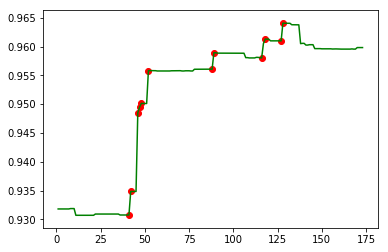

In [87]:
plot(range(1, len(order_keys)), o_tp, '-g', label='True Positive');

scatter(41, o_tp[40], color='red');
scatter(52, o_tp[51], color='red');

scatter(42, o_tp[41], color='red');
scatter(46, o_tp[45], color='red');
scatter(47, o_tp[46], color='red');
scatter(48, o_tp[47], color='red');

scatter(88, o_tp[87], color='red');
scatter(89, o_tp[88], color='red');

scatter(116, o_tp[115], color='red');
scatter(118, o_tp[117], color='red');

scatter(127, o_tp[126], color='red');
scatter(128, o_tp[127], color='red');

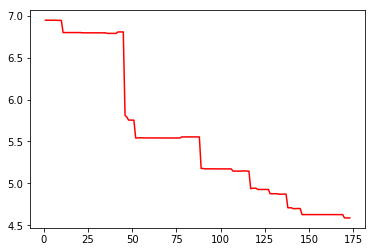

In [32]:
plot(range(1, len(order_keys)), np.array(o_averages), '-r', label='Answers Count (Average)');

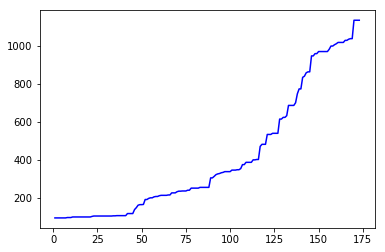

In [33]:
plot(range(1, len(order_keys)), np.array(o_shapes), '-b', label='Order features shape');

### Select greatest keys

In [141]:
real_keys = list(order_keys)
important_order_keys = []

for n in range(41, 53):
    important_order_keys.append(real_keys[n])
    
for n in range(88, 90):
    important_order_keys.append(real_keys[n])
    
for n in range(116, 119):
    important_order_keys.append(real_keys[n])
    
for n in range(127, 129):
    important_order_keys.append(real_keys[n])
    
important_order_keys

['X-Ucbrowser-Ua',
 'Upgrade-Insecure-Requests',
 'X-Original-Url',
 'Drm-Version',
 'Useragent',
 'Accept',
 'Save-Data',
 'If-Modified-Since',
 'X-Liveinternetapplications',
 'Wap-Connection',
 'O2gw-Id',
 'Host',
 'X-Pocket-Parser',
 'Connection',
 'Giga-Transport',
 'User-Agent',
 'From',
 'X-Requestfrom',
 'Accept-Encoding']

In [142]:
order_keys = set(important_order_keys)

order_data_top_100 = []

for row_index in range(len(order_data)):
    tmp_row = {}
    for key in order_data[row_index].keys():
        if key in set(important_order_keys):
            tmp_row[key] = order_data[row_index][key]
    if row_index in main_top_100.index:
        order_data_top_100.append(tmp_row)

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)
    
pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

 32%|███▏      | 57471/181851 [00:00<00:00, 574707.81it/s]

Sparse dummy orders shape: 
(181851, 84)


100%|██████████| 181851/181851 [00:00<00:00, 586750.71it/s]


Sparse dummy values shape: 
(181851, 93)


60011it [00:01, 37828.72it/s]


sparse_dummy_values.shape: (181851, 177)
Answers Count (Average) = 5.03685990901668
True Positive = 0.9663561680358601


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,7
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,15
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,15
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


In [75]:
important_order_keys = []

for n in range(41, 53):
    important_order_keys.append(real_keys[n])
    
important_order_keys

['X-Ucbrowser-Ua',
 'Upgrade-Insecure-Requests',
 'X-Original-Url',
 'Drm-Version',
 'Useragent',
 'Accept',
 'Save-Data',
 'If-Modified-Since',
 'X-Liveinternetapplications',
 'Wap-Connection',
 'O2gw-Id',
 'Host']

In [76]:
order_keys = set(important_order_keys)

order_data_top_100 = []

for row_index in range(len(order_data)):
    tmp_row = {}
    for key in order_data[row_index].keys():
        if key in real_keys:
            tmp_row[key] = order_data[row_index][key]
    if row_index in main_top_100.index:
        order_data_top_100.append(tmp_row)

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)
    
pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

 30%|██▉       | 54468/181851 [00:00<00:00, 544672.73it/s]

Sparse dummy orders shape: 
(181851, 1042)


100%|██████████| 181851/181851 [00:00<00:00, 562430.46it/s]


Sparse dummy values shape: 
(181851, 93)


60011it [00:01, 35122.46it/s]


sparse_dummy_values.shape: (181851, 1135)
Answers Count (Average) = 4.587975537818067
True Positive = 0.9598240322607522


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,5
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


In [77]:
important_order_keys = []

for n in range(41, 53):
    important_order_keys.append(real_keys[n])

important_order_keys.append(real_keys[90])
important_order_keys.append(real_keys[119])
important_order_keys.append(real_keys[129])

In [78]:
order_keys = set(important_order_keys)

order_data_top_100 = []

for row_index in range(len(order_data)):
    tmp_row = {}
    for key in order_data[row_index].keys():
        if key in real_keys:
            tmp_row[key] = order_data[row_index][key]
    if row_index in main_top_100.index:
        order_data_top_100.append(tmp_row)

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)
    
pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

 33%|███▎      | 59786/181851 [00:00<00:00, 597854.87it/s]

Sparse dummy orders shape: 
(181851, 1042)


100%|██████████| 181851/181851 [00:00<00:00, 563213.30it/s]


Sparse dummy values shape: 
(181851, 93)


60011it [00:01, 38875.93it/s]

sparse_dummy_values.shape: (181851, 1135)
Answers Count (Average) = 4.587975537818067
True Positive = 0.9598240322607522


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,5
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


In [91]:
important_order_keys = []

important_order_keys.append(real_keys[42])
important_order_keys.append(real_keys[46])
important_order_keys.append(real_keys[47])
important_order_keys.append(real_keys[48])
important_order_keys.append(real_keys[52])
important_order_keys.append(real_keys[89])
important_order_keys.append(real_keys[118])
important_order_keys.append(real_keys[128])

important_order_keys

['Upgrade-Insecure-Requests',
 'Accept',
 'Save-Data',
 'If-Modified-Since',
 'Host',
 'Connection',
 'From',
 'Accept-Encoding']

In [92]:
order_keys = set(important_order_keys)

order_data_top_100 = []

for row_index in range(len(order_data)):
    tmp_row = {}
    for key in order_data[row_index].keys():
        if key in real_keys:
            tmp_row[key] = order_data[row_index][key]
    if row_index in main_top_100.index:
        order_data_top_100.append(tmp_row)

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)
    
pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

 31%|███       | 56483/181851 [00:00<00:00, 564819.77it/s]

Sparse dummy orders shape: 
(181851, 1042)


100%|██████████| 181851/181851 [00:00<00:00, 526629.00it/s]


Sparse dummy values shape: 
(181851, 93)


60011it [00:01, 36309.84it/s]

sparse_dummy_values.shape: (181851, 1135)
Answers Count (Average) = 4.587975537818067
True Positive = 0.9598240322607522


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,5
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


In [93]:
%%time

real_keys = []
o_shapes = []
o_averages = []
o_tp = []

for key in tqdm(order_keys):
    real_keys.append(key)
    if len(real_keys) < 2:
        continue

    order_data_top_100 = []

    for row_index in range(len(order_data)):
        tmp_row = {}
        for key in order_data[row_index].keys():
            if key in real_keys:
                tmp_row[key] = order_data[row_index][key]
        if row_index in main_top_100.index:
            order_data_top_100.append(tmp_row)

    l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

    full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

    X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

    clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
    clf.fit(X_train, y_train)
    
    pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
    y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)
    
    o_shapes.append(full_sparce_dummy.shape[1])
    o_averages.append(np.average(answers_count))
    o_tp.append(np.sum(compare_answers) / y_test.shape[0])

 33%|███▎      | 60584/181851 [00:00<00:00, 605833.36it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 593628.93it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3604it [00:00, 36035.82it/s]
7194it [00:00, 35994.85it/s]
10892it [00:00, 36284.06it/s]
14568it [00:00, 36424.31it/s]
18223it [00:00, 36460.30it/s]
21819it [00:00, 36306.90it/s]
25121it [00:00, 35037.83it/s]
28497it [00:00, 34642.46it/s]
32108it [00:00, 35068.15it/s]
35564it [00:01, 34911.91it/s]
38998it [00:01, 34735.94it/s]
42596it [00:01, 35099.43it/s]
46217it [00:01, 35423.21it/s]
49876it [00:01, 35762.47it/s]
53472it [00:01, 35817.86it/s]
57149it [00:01, 36098.07it/s]
 34%|███▍      | 62708/181851 [00:00<00:00, 627071.63it/s]

Sparse dummy orders shape: 
(181851, 6)



100%|██████████| 181851/181851 [00:00<00:00, 614895.39it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3595it [00:00, 35944.81it/s]
7228it [00:00, 36058.82it/s]
10845it [00:00, 36090.80it/s]
14433it [00:00, 36025.19it/s]
17993it [00:00, 35894.82it/s]
21610it [00:00, 35975.20it/s]
25225it [00:00, 36025.73it/s]
28922it [00:00, 36302.62it/s]
32692it [00:00, 36708.54it/s]
36408it [00:01, 36842.49it/s]
40086it [00:01, 36821.31it/s]
43777it [00:01, 36846.96it/s]
47452it [00:01, 36812.69it/s]
51143it [00:01, 36838.47it/s]
54804it [00:01, 36766.68it/s]
58464it [00:01, 36632.42it/s]
 37%|███▋      | 66602/181851 [00:00<00:00, 666017.46it/s]

Sparse dummy orders shape: 
(181851, 12)



100%|██████████| 181851/181851 [00:00<00:00, 663712.48it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3723it [00:00, 37228.08it/s]
7492it [00:00, 37365.21it/s]
11257it [00:00, 37447.54it/s]
15043it [00:00, 37569.46it/s]
18821it [00:00, 37631.93it/s]
22594it [00:00, 37660.50it/s]
26434it [00:00, 37876.63it/s]
30225it [00:00, 37884.51it/s]
33890it [00:00, 37504.12it/s]
37653it [00:01, 37541.46it/s]
41428it [00:01, 37603.44it/s]
45160it [00:01, 37517.70it/s]
48913it [00:01, 37516.92it/s]
52713it [00:01, 37660.37it/s]
56455it [00:01, 37470.79it/s]
 36%|███▋      | 66258/181851 [00:00<00:00, 662571.15it/s]

Sparse dummy orders shape: 
(181851, 18)



100%|██████████| 181851/181851 [00:00<00:00, 659423.81it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3711it [00:00, 37109.15it/s]
7509it [00:00, 37364.64it/s]
11336it [00:00, 37630.96it/s]
15127it [00:00, 37713.18it/s]
18889it [00:00, 37683.49it/s]
22658it [00:00, 37684.75it/s]
26429it [00:00, 37692.04it/s]
30010it [00:00, 37104.95it/s]
33671it [00:00, 36952.36it/s]
37431it [00:01, 37142.76it/s]
41088it [00:01, 36968.10it/s]
44833it [00:01, 37110.17it/s]
48598it [00:01, 37267.99it/s]
52365it [00:01, 37387.67it/s]
56174it [00:01, 37594.88it/s]
59927it [00:01, 37572.74it/s]
 37%|███▋      | 67816/181851 [00:00<00:00, 678155.80it/s]

Sparse dummy orders shape: 
(181851, 27)



100%|██████████| 181851/181851 [00:00<00:00, 669777.31it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3724it [00:00, 37234.09it/s]
7482it [00:00, 37335.21it/s]
11249it [00:00, 37432.48it/s]
14974it [00:00, 37376.51it/s]
18725it [00:00, 37416.31it/s]
22247it [00:00, 36724.32it/s]
25852it [00:00, 36516.96it/s]
29576it [00:00, 36730.07it/s]
33230it [00:00, 36671.95it/s]
37025it [00:01, 37042.73it/s]
40806it [00:01, 37267.61it/s]
44590it [00:01, 37436.53it/s]
48284it [00:01, 37073.27it/s]
52026it [00:01, 37175.80it/s]
55795it [00:01, 37327.77it/s]
59530it [00:01, 37331.75it/s]
 36%|███▌      | 64680/181851 [00:00<00:00, 646794.45it/s]

Sparse dummy orders shape: 
(181851, 38)



100%|██████████| 181851/181851 [00:00<00:00, 657512.11it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3713it [00:00, 37127.56it/s]
7459it [00:00, 37224.19it/s]
11215it [00:00, 37322.75it/s]
14931it [00:00, 37271.70it/s]
18670it [00:00, 37306.59it/s]
22365it [00:00, 37197.64it/s]
26067it [00:00, 37142.77it/s]
29776it [00:00, 37125.42it/s]
33520it [00:00, 37218.43it/s]
37219it [00:01, 37148.87it/s]
40935it [00:01, 37149.21it/s]
44687it [00:01, 37257.20it/s]
48405it [00:01, 37233.91it/s]
52155it [00:01, 37311.68it/s]
55864it [00:01, 37244.29it/s]
59608it [00:01, 37302.75it/s]
 36%|███▋      | 66102/181851 [00:00<00:00, 661011.17it/s]

Sparse dummy orders shape: 
(181851, 51)



100%|██████████| 181851/181851 [00:00<00:00, 658956.66it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3663it [00:00, 36622.00it/s]
7372it [00:00, 36759.26it/s]
11091it [00:00, 36887.18it/s]
14824it [00:00, 37017.62it/s]
18545it [00:00, 37072.25it/s]
22280it [00:00, 37155.10it/s]
26018it [00:00, 37221.61it/s]
29830it [00:00, 37485.21it/s]
33532it [00:00, 37342.17it/s]
37261it [00:01, 37324.91it/s]
40936it [00:01, 37149.63it/s]
44691it [00:01, 37268.22it/s]
48393it [00:01, 37191.25it/s]
52190it [00:01, 37420.16it/s]
55908it [00:01, 37167.68it/s]
59637it [00:01, 37202.89it/s]
100%|██████████| 8/8 [09:20<00:00, 83.98s/it]

CPU times: user 9min 18s, sys: 896 ms, total: 9min 19s
Wall time: 9min 20s


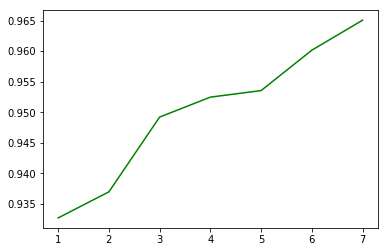

In [94]:
plot(range(1, len(order_keys)), o_tp, '-g', label='True Positive');

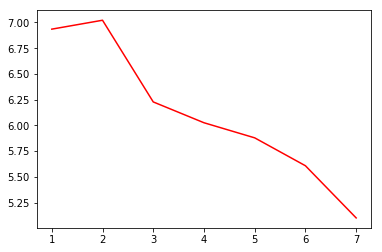

In [95]:
plot(range(1, len(order_keys)), np.array(o_averages), '-r', label='Answers Count (Average)');

In [145]:
"""
important_order_keys = [
    'Upgrade-Insecure-Requests',
    'Accept',
    'If-Modified-Since',
    'Host',
    'Connection',
    'From',
    'Accept-Encoding']
"""
important_order_keys = [
    'X-Ucbrowser-Ua',
    'Upgrade-Insecure-Requests',
    'X-Original-Url',
    'Drm-Version',
    'Useragent',
    'Accept',
    'Save-Data',
    'If-Modified-Since',
    'X-Liveinternetapplications',
    'Wap-Connection',
    'O2gw-Id',
    'Host',
    'X-Pocket-Parser',
    'Connection',
    'Giga-Transport',
    'User-Agent',
    'From',
    'X-Requestfrom',
    'Accept-Encoding'
]

In [ ]:
%%time

order_keys = set(important_order_keys)

real_keys = []
o_shapes = []
o_averages = []
o_tp = []

for key in tqdm(order_keys):
    real_keys.append(key)
    #if len(real_keys) < 2:
    #    continue

    order_data_top_100 = []

    for row_index in range(len(order_data)):
        tmp_row = {}
        for key in order_data[row_index].keys():
            if key in real_keys:
                tmp_row[key] = order_data[row_index][key]
        if row_index in main_top_100.index:
            order_data_top_100.append(tmp_row)

    l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

    full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

    X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

    clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
    clf.fit(X_train, y_train)
    
    pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
    y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)
    
    o_shapes.append(full_sparce_dummy.shape[1])
    o_averages.append(np.average(answers_count))
    o_tp.append(np.sum(compare_answers) / y_test.shape[0])

 33%|███▎      | 60451/181851 [00:00<00:00, 604507.69it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 619408.49it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3836it [00:00, 38359.58it/s]
7718it [00:00, 38494.93it/s]
11563it [00:00, 38480.73it/s]
15441it [00:00, 38569.32it/s]
19335it [00:00, 38679.30it/s]
23199it [00:00, 38666.68it/s]
27039it [00:00, 38586.19it/s]
30891it [00:00, 38565.80it/s]
34755it [00:00, 38587.43it/s]
38586it [00:01, 38503.52it/s]
42395it [00:01, 38377.54it/s]
46215it [00:01, 38323.81it/s]
50056it [00:01, 38349.45it/s]
53861it [00:01, 38258.06it/s]
57713it [00:01, 38333.57it/s]
 36%|███▋      | 66132/181851 [00:00<00:00, 661309.59it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 663997.90it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3862it [00:00, 38613.78it/s]
7743it [00:00, 38671.62it/s]
11631it [00:00, 38731.76it/s]
15514it [00:00, 38759.64it/s]
19406it [00:00, 38806.57it/s]
23288it [00:00, 38808.33it/s]
27148it [00:00, 38745.08it/s]
30879it [00:00, 38300.15it/s]
34731it [00:00, 38365.58it/s]
38591it [00:01, 38433.92it/s]
42439it [00:01, 38446.10it/s]
46315it [00:01, 38537.96it/s]
50178it [00:01, 38564.66it/s]
54019it [00:01, 38516.32it/s]
57845it [00:01, 38163.57it/s]
 37%|███▋      | 68067/181851 [00:00<00:00, 680662.54it/s]

Sparse dummy orders shape: 
(181851, 0)



100%|██████████| 181851/181851 [00:00<00:00, 679283.02it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3649it [00:00, 36488.64it/s]
7334it [00:00, 36593.32it/s]
11099it [00:00, 36902.19it/s]
14818it [00:00, 36985.87it/s]
18548it [00:00, 37077.11it/s]
22252it [00:00, 37064.49it/s]
25982it [00:00, 37133.23it/s]
29741it [00:00, 37268.52it/s]
33385it [00:00, 37014.03it/s]
37128it [00:01, 37137.62it/s]
40891it [00:01, 37282.03it/s]
44650it [00:01, 37373.00it/s]
48452it [00:01, 37564.33it/s]
52208it [00:01, 37561.89it/s]
55940it [00:01, 37318.69it/s]
59721it [00:01, 37463.66it/s]
 35%|███▌      | 63912/181851 [00:00<00:00, 639112.99it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 644812.49it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3762it [00:00, 37617.52it/s]
7597it [00:00, 37831.68it/s]
11368it [00:00, 37792.31it/s]
15138it [00:00, 37762.31it/s]
18887it [00:00, 37678.97it/s]
22609it [00:00, 37537.40it/s]
26253it [00:00, 37199.84it/s]
30005it [00:00, 37294.53it/s]
33611it [00:00, 36913.21it/s]
37317it [00:01, 36955.02it/s]
40953it [00:01, 36774.01it/s]
44697it [00:01, 36969.65it/s]
48464it [00:01, 37174.63it/s]
52240it [00:01, 37346.54it/s]
56019it [00:01, 37476.36it/s]
59750it [00:01, 37409.75it/s]
 35%|███▌      | 64015/181851 [00:00<00:00, 640144.51it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 639872.06it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3758it [00:00, 37566.42it/s]
7559it [00:00, 37696.30it/s]
11302it [00:00, 37615.97it/s]
15098it [00:00, 37716.55it/s]
18874it [00:00, 37726.81it/s]
22658it [00:00, 37759.76it/s]
26408it [00:00, 37680.09it/s]
30180it [00:00, 37691.01it/s]
33948it [00:00, 37687.13it/s]
37737it [00:01, 37747.07it/s]
41548it [00:01, 37853.43it/s]
45260it [00:01, 37615.44it/s]
49021it [00:01, 37612.90it/s]
52867it [00:01, 37860.22it/s]
56653it [00:01, 37858.70it/s]
 35%|███▍      | 63466/181851 [00:00<00:00, 634654.55it/s]

Sparse dummy orders shape: 
(181851, 2)



100%|██████████| 181851/181851 [00:00<00:00, 640442.65it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3736it [00:00, 37357.19it/s]
7499it [00:00, 37438.49it/s]
11302it [00:00, 37613.43it/s]
15079it [00:00, 37659.09it/s]
18854it [00:00, 37683.53it/s]
22292it [00:00, 36626.57it/s]
25982it [00:00, 36705.83it/s]
29761it [00:00, 37023.23it/s]
33319it [00:00, 36576.46it/s]
37078it [00:01, 36873.74it/s]
40752it [00:01, 36833.13it/s]
44396it [00:01, 36713.94it/s]
48107it [00:01, 36829.71it/s]
51756it [00:01, 36576.14it/s]
55402it [00:01, 36540.86it/s]
59205it [00:01, 36974.22it/s]
 35%|███▌      | 64073/181851 [00:00<00:00, 640726.03it/s]

Sparse dummy orders shape: 
(181851, 6)



100%|██████████| 181851/181851 [00:00<00:00, 642295.18it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3741it [00:00, 37402.19it/s]
7511it [00:00, 37490.94it/s]
11256it [00:00, 37476.17it/s]
15041it [00:00, 37586.67it/s]
18799it [00:00, 37582.61it/s]
22559it [00:00, 37585.55it/s]
26308it [00:00, 37556.28it/s]
30064it [00:00, 37555.07it/s]
33917it [00:00, 37841.04it/s]
37695it [00:01, 37821.61it/s]
41504it [00:01, 37901.44it/s]
45275it [00:01, 37842.57it/s]
49054it [00:01, 37825.14it/s]
52808it [00:01, 37737.50it/s]
56583it [00:01, 37739.64it/s]
 36%|███▌      | 64589/181851 [00:00<00:00, 645887.54it/s]

Sparse dummy orders shape: 
(181851, 7)



100%|██████████| 181851/181851 [00:00<00:00, 638098.58it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3737it [00:00, 37365.49it/s]
7514it [00:00, 37484.48it/s]
11297it [00:00, 37586.07it/s]
15040it [00:00, 37537.80it/s]
18836it [00:00, 37661.85it/s]
22559it [00:00, 37527.44it/s]
26326it [00:00, 37568.10it/s]
30086it [00:00, 37576.44it/s]
33770it [00:00, 37351.63it/s]
37531it [00:01, 37427.90it/s]
41297it [00:01, 37495.00it/s]
45072it [00:01, 37570.91it/s]
48842it [00:01, 37609.47it/s]
52619it [00:01, 37657.17it/s]
56380it [00:01, 37642.64it/s]
 35%|███▌      | 64326/181851 [00:00<00:00, 643256.01it/s]

Sparse dummy orders shape: 
(181851, 7)



100%|██████████| 181851/181851 [00:00<00:00, 625752.93it/s]

Sparse dummy values shape: 
(181851, 93)



0it [00:00, ?it/s]
3700it [00:00, 36999.51it/s]
7379it [00:00, 36936.02it/s]
11112it [00:00, 37053.21it/s]
14894it [00:00, 37277.43it/s]
18621it [00:00, 37272.62it/s]
22411it [00:00, 37457.41it/s]
26164it [00:00, 37477.78it/s]
29909it [00:00, 37469.37it/s]
33609it [00:00, 37326.03it/s]
37343it [00:01, 37329.88it/s]
40972it [00:01, 36249.42it/s]
44531it [00:01, 35811.50it/s]
48211it [00:01, 36102.34it/s]
51881it [00:01, 36277.95it/s]
55594it [00:01, 36527.90it/s]
59275it [00:01, 36610.39it/s]
 34%|███▎      | 61238/181851 [00:00<00:00, 612376.20it/s]

Sparse dummy orders shape: 
(181851, 7)



100%|██████████| 181851/181851 [00:00<00:00, 616516.66it/s]

Sparse dummy values shape: 
(181851, 93)


In [ ]:
plot(range(len(order_keys)), o_tp, '-g', label='True Positive');

o_tp[-1]

In [ ]:
plot(range(len(order_keys)), np.array(o_averages), '-r', label='Answers Count (Average)');

o_averages[-1]

In [ ]:
plot(range(len(order_keys)), np.array(o_shapes), '-b', label='Order features shape');

o_shapes[-1]

In [144]:
order_keys = set(important_order_keys)

order_data_top_100 = []

for row_index in range(len(order_data)):
    tmp_row = {}
    for key in order_data[row_index].keys():
        if key in order_keys:
            tmp_row[key] = order_data[row_index][key]
    if row_index in main_top_100.index:
        order_data_top_100.append(tmp_row)

l_parser.reassign_orders_values(order_data_top_100, values_data_top_100)

full_sparce_dummy = l_parser.prepare_data(orders_vectorizer, values_vectorizer, important_keys_set, fit_dict=True)

X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
clf.fit(X_train, y_train)
    
pred = ThresholdPredictions(user_agent_list=list_ua, clf=clf)
y_test_names, y_predicted, compare_answers, answers_count = pred.predict(X_test, y_test, 0.024072)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

#print('Headers: ' + str(' '.join(important_keys)))
print('sparse_dummy_values.shape: ' + str(full_sparce_dummy.shape))
print("Answers Count (Average) = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

 37%|███▋      | 67593/181851 [00:00<00:00, 675929.03it/s]

Sparse dummy orders shape: 
(181851, 40)


100%|██████████| 181851/181851 [00:00<00:00, 652037.98it/s]


Sparse dummy values shape: 
(181851, 93)


60011it [00:01, 37062.87it/s]

sparse_dummy_values.shape: (181851, 133)
Answers Count (Average) = 5.111612870973655
True Positive = 0.9649230974321374


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,6
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,15
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,15
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1; rv:51.0) Gecko/2...,True,2
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


## Conclusion


important_order_keys are

```
{
    'Upgrade-Insecure-Requests',
    'Accept',
    'If-Modified-Since',
    'Host',
    'Connection',
    'From',
    'Accept-Encoding'
}
```